In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
import pandas as pd
import xvec
import dataframe_image as dfi
from core.utils import get_cluster_names

v = 'v10'

regions = gpd.read_parquet('/data/uscuni-ulce/regions/cadastre_regions_hull.parquet')

In [4]:
cluster_mapping.loc[22]

1     1
2     2
3     3
4     4
5     6
6    11
Name: 22, dtype: int32

## 0. Hierarchy & Results

## 1. Cluster characteristics

In [2]:
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')

In [ ]:
# regional clustering load

results = []
for region_id, region_hull in regions.iterrows():

    print(region_id)

    # setup regional data
    region_clusters = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq', columns=['final_without_noise']).final_without_noise
    # region_clusters = region_clusters.map(cluster_mapping[3].to_dict())

    region_data = pd.read_parquet(f'/data/uscuni-ulce/processed_data/chars/primary_chars_{region_id}.parquet')
    region_data = region_data.loc[region_clusters.index]

    region_data['label'] = region_clusters

    results.append(region_data)

all_data = pd.concat(results, ignore_index=True)

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


In [5]:
from core.utils import used_keys
new_keys = used_keys.copy()
new_keys['limLPS'] = 'building structure optimised for sunlight'
new_keys['limAre'] = 'sum of the largest 75 building areas in the morphotope'
new_keys["limPer"] = 'sum of the largest 75 building perimeters in the morphotope'
new_keys["limLAL"] = 'sum of the largest 75 axis lengths'

In [6]:
# remap to cut
all_data['label'] = all_data['label'].map(cluster_mapping[3].to_dict())

In [7]:
all_data['label'].value_counts()

label
7    34554418
5    12840909
4    11733158
3     7383591
8     7186509
1     3277945
2     2388970
6     1430313
Name: count, dtype: int64

In [8]:
## doesnt include indicator var, since that is a morphotope variable...
cluster_centres = all_data.groupby('label').mean()
cluster_centres.columns = cluster_centres.columns.map(new_keys)
table_data = cluster_centres

In [9]:
cols1 = table_data.columns[:table_data.columns.shape[0] // 2]
cols2 = table_data.columns[table_data.columns.shape[0] // 2:]

#### get a subset of differentiating variables

In [10]:
linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/clusters/kmeans_linkage_{v}.npy')
regional_ward_morphotopes_data = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_input_data_{v}.pq')

In [11]:
from scipy.cluster.hierarchy import fcluster
final_cutoff = 1/4 -0.00001
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)

cinput_data = regional_ward_morphotopes_data.groupby(final_clusters).median()
total_median = regional_ward_morphotopes_data.median()


results = []
for i, row_data in cinput_data.iterrows():
    diffs = row_data - total_median
    top_diffs = ((diffs) ** 2).sort_values().iloc[-10:]
    top_diffs = diffs.loc[top_diffs.index].sort_values(ascending=False)
    results.append(top_diffs.index.values)

col_subset = np.unique(results)
col_subset.shape

(52,)

#### plot tables

In [11]:
cluster_centres = all_data.groupby('label').mean()

In [ ]:
col_keys = new_keys.copy()
to_drop = ['stcSAl','stbOri','stcOri','stbCeA',
               'ldkAre', 'ldkPer', 'lskCCo', 'lskERI',
               'lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
              'licBAD',
              'misBAD',
               'ssbCCM',
               'ssbCCD'
              ]

for k in to_drop:
    col_keys.pop(k, None)

In [13]:
# cluster_centres['limLPS'] = [2.0] * 9 + [-4.8, 2, 2, 2, 2, -4.8, 2]
table_data = cluster_centres.loc[:, cluster_centres.columns[cluster_centres.columns.isin(list(col_keys.keys()))]]
table_data.columns = [col_keys[k] for k in table_data.columns]
table_data.index = table_data.index.map(get_cluster_names(3)).values

In [14]:
cols1 = table_data.columns[:table_data.columns.shape[0] // 2]
cols2 = table_data.columns[table_data.columns.shape[0] // 2:]

In [15]:
table = table_data.loc[:, cols1]
f = {
    k: "{:.2f}" for k in table_data.columns.values
}
table = table.style.format(f).background_gradient(axis=0, cmap="BuGn")
table

In [16]:
await dfi.export_async(table, '../data/features1.png')

In [17]:
table = table_data.loc[:, cols2]
f = {
    k: "{:.2f}" for k in table_data.columns.values
}
table2 = table.style.format(f).background_gradient(axis=0, cmap="BuGn")
table2

In [18]:
await dfi.export_async(table2, '../data/features2.png')

In [ ]:
selected_cols = ['area of building', 'courtyard area of building', 'shared walls ratio of buildings',
                 'street alignment of building',
                 'mean distance between neighbouring buildings', 'alignment of neighbouring buildings',
                 'buildings per meter of street segment',

                 'length of street segment', 'width of street profile', 'linearity of street segment',
                 'local proportion of cul-de-sacs of street network', 'node degree of junction',
                 'square clustering of street network', 'mean distance to neighbouring nodes of street network',

                 'area of ETC', 'perimeter-weighted neighbours of ETC',

                 'connected buildings count', 'connected buildings facade ratio', 'deviation of building area in tess. neighbourhood']
table = table_data.loc[:, selected_cols]
f = {
    k: "{:.2f}" for k in table_data.columns.values
}
table.loc[['Dense Connected Developments', 'Large Interconnected Blocks',
       'Dense Standalone Buildings', 'Compact Development',
       'Cul-de-Sac Layout', 'Aligned Winding Streets',
       'Sparse Rural Development',
       'Dispersed Linear Development', 'Linear Development',
       'Sparse Open Layout', 'Sparse Road-Linked Development',
       'Large Utilitarian Development', 'Extensive Wide-Spaced Developments']].style.format(f).background_gradient(axis=0, cmap="BuGn")

In [18]:
del all_data
del results

## 2. Corrine LandCover

In [2]:
# !wget https://copernicus-fme.eea.europa.eu/clmsdatadownload/results/146146.zip

In [3]:
# !mv 146146.zip /data/uscuni-ulce/validation/

In [4]:
corrine = gpd.read_file('/data/uscuni-ulce/validation/Results/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'U2018_CLC2018_V2020_20u1.gpkg': 'U2018_CLC2018_V2020_20u1' (default), 'U2018_CLC2018_V2020_20u1_FR_REU', 'U2018_CLC2018_V2020_20u1_FR_GLP', 'U2018_CLC2018_V2020_20u1_FR_GUF', 'U2018_CLC2018_V2020_20u1_FR_MTQ', 'U2018_CLC2018_V2020_20u1_FR_MYT'. Specify layer parameter to avoid this warning.
  result = read_func(


In [ ]:
%%time
results = []
for region_id, region_hull in regions.iterrows():
    print(region_id)
    # setup regional data
    buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq')
    regional_corrine = corrine[corrine.intersects(region_hull.convex_hull)].explode()

    ## spatially join buildings and corrine areas
    inp, res = buildings.centroid.sindex.query(regional_corrine.geometry, predicate='intersects')
    assert (pd.Series(res).value_counts() == 1).all()
    buildings['Code_18'] = ''
    buildings.iloc[res, -1] = regional_corrine.iloc[inp, 0]

    results.append(buildings)

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


In [6]:
%%time
all_data = pd.concat(results, ignore_index=True)

CPU times: user 16.5 s, sys: 5.28 s, total: 21.8 s
Wall time: 21.8 s


In [7]:
%%time
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')
all_data['map_label'] = all_data['final_without_noise'].map(cluster_mapping[3].to_dict())

CPU times: user 262 ms, sys: 207 ms, total: 469 ms
Wall time: 478 ms


In [8]:
corrine_legend = {
    "111": "Continuous urban fabric",
    "112": "Discontinuous urban fabric",
    "121": "Industrial or commercial units",
    "122": "Road and rail networks and associated land",
    "123": "Port areas",
    "124": "Airports",
    "131": "Mineral extraction sites",
    "132": "Dump sites",
    "133": "Construction sites",
    "141": "Green urban areas",
    "142": "Sport and leisure facilities",
    "211": "Non-irrigated arable land",
    "212": "Permanently irrigated land",
    "213": "Rice fields",
    "221": "Vineyards",
    "222": "Fruit trees and berry plantations",
    "223": "Olive groves",
    "231": "Pastures",
    "241": "Annual crops associated with permanent crops",
    "242": "Complex cultivation patterns",
    "243": "Land principally occupied by agriculture, with significant areas of natural vegetation",
    "244": "Agro-forestry areas"
}

In [9]:
himoc_corrine_cross_tab = pd.crosstab(all_data.map_label, all_data.Code_18, normalize='index')

# drop non-urban columns
relevant_corrine_columns = himoc_corrine_cross_tab.columns[himoc_corrine_cross_tab.columns.str.startswith('1') | himoc_corrine_cross_tab.columns.str.startswith('2')]
himoc_corrine_cross_tab = himoc_corrine_cross_tab.loc[:, relevant_corrine_columns]

# map keys to names
himoc_corrine_cross_tab.index = himoc_corrine_cross_tab.index.map(get_cluster_names(3)).values
himoc_corrine_cross_tab.columns = himoc_corrine_cross_tab.columns.map(corrine_legend).values

In [ ]:
# focus only on relative classes
himoc_corrine_cross_tab = himoc_corrine_cross_tab[['Continuous urban fabric', 'Discontinuous urban fabric', 'Industrial or commercial units', 'Non-irrigated arable land',
                         'Pastures', 'Complex cultivation patterns', 'Land principally occupied by agriculture, with significant areas of natural vegetation']]

In [11]:
f = {
    k: "{:.2f}" for k in himoc_corrine_cross_tab.columns.values
}
styled_table = himoc_corrine_cross_tab.style.format(f).background_gradient(axis=1, cmap="BuGn")
styled_table

In [12]:
await dfi.export_async(styled_table, '../data/corine.png', dpi=300)

1. The clusters broadly follow the higher level patterns that are described by the corrine land cover classification
    - the Large Utilitarian Development	, Massive Connected Aggregations, Extensive Courtyard Complexes	, Large Wide-Spaced Complexes are mostly industrial units.
    - Large Interconnected Blocks	is the most urban cluster and half of it is contiguous urban fabric
    - Other types of clusters mostly fall within the Discontinuous urban fabric	cluster, which is expected
    - The sparse development captures some aggriculture and developed land patterns
2. We split the classes into different sub classes, providing more information
   - Discontinuous urban fabric is split into various classes based on the density, street characteristics and overall distances between buildings.
   - Similarly for the less developed clusters such as Linear Development, Sparse Road-Linked Development, Sparse Rural Development	 which contain lots of villages.

## 3. Urban atlas

In [1]:
# !wget https://copernicus-fme.eea.europa.eu/clmsdatadownload/results/145772.zip

In [2]:
# !mv 145772.zip /data/uscuni-ulce/validation/

### Generate data

In [5]:
from glob import glob

furl = '/data/uscuni-ulce/validation/Results/'
files = glob(furl + 'AT*') + glob(furl + 'CZ*') + glob(furl + 'SK*') + glob(furl + 'PL*') + glob(furl + 'DE*') + glob(furl + 'LT*')
files

['/data/uscuni-ulce/validation/Results/AT003L3_LINZ_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT005L3_INNSBRUCK_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT004L3_SALZBURG_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT001L3_WIEN_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT002L3_GRAZ_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/AT006L2_KLAGENFURT_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ004L2_PLZEN_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ001L2_PRAHA_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ011L2_ZLIN_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ014L2_JIHLAVA_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ013L2_KARLOVY_VARY_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ016L2_MOST_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ003L2_OSTRAVA_UA2018_v013.zip',
 '/data/uscuni-ulce/validation/Results/CZ009L2_HRADEC_KRALO

In [6]:
%%time

# read the boundaries of the available functinal areas

urban_atlast_regions = []

for f in files:
    zipname = f.split('/')[-1][:-4]
    gpkg_path = f + '!' + zipname + "/Data/" + zipname + '.gpkg'

    data = gpd.read_file(gpkg_path, layer=zipname[:-5] + '_Boundary')
    data['filepath'] = gpkg_path
    urban_atlast_regions.append(data)

urban_atlast_regions = pd.concat(urban_atlast_regions, ignore_index=True)

CPU times: user 41.6 s, sys: 1.38 s, total: 42.9 s
Wall time: 43.2 s


In [7]:
urban_atlast_regions.iloc[-30:]

fid_1 country fua_code                           fua_name      perimeter  \
159   72.0      DE  DE002L1                            Hamburg  714228.674363   
160  136.0      DE  DE082L0                      Dessau-Roßlau  115540.091580   
161   95.0      DE  DE032L1                             Erfurt  478935.510935   
162  159.0      DE  DE539L1                            Cottbus  260666.456167   
163  107.0      DE  DE045L1                           Iserlohn  199593.747289   
164  116.0      DE  DE057L1                             Gießen  216092.323233   
165  164.0      DE  DE547L2                               Jena  198539.425723   
166  137.0      DE  DE083L1  Braunschweig-Salzgitter-Wolfsburg  454346.145171   
167  131.0      DE  DE074L1                            Görlitz  341851.373359   
168   87.0      DE  DE021L1                          Göttingen  381999.868112   
169  166.0      DE  DE549L1                            Bocholt  272346.008824   
170  142.0      DE  DE508L0                            Krefeld   63066.134203   
171  128.0      DE  DE071L1                          Stralsund  841531.879238   
172  126.0      DE  DE067L1                           Landshut  285157.138179   
173  132.0      DE  DE077L1                        Schweinfurt  432291.774031   
174  117.0      DE  DE058L1                           Lüneburg  318934.113603   
175  108.0      DE  DE048L1                      Wilhelmshaven  212752.172182   
176  145.0      DE  DE516L0                           Solingen   59961.724450   
177  111.0      DE  DE052L1                          Flensburg  408973.374680   
178  133.0      DE  DE078L1                         Greifswald  706888.874279   
179   88.0      DE  DE025L1                          Darmstadt  159582.740691   
180  124.0      DE  DE065L1                              Fulda  246391.063679   
181   77.0      DE  DE008L2                            Leipzig  415582.912569   
182   98.0      DE  DE035L1                          Karlsruhe  226500.587829   
183  464.0      LT  LT001L1                            Vilnius  427876.799906   
184  468.0      LT  LT501L0                           Klaipėda   82286.684933   
185  467.0      LT  LT004L0                             Alytus   43215.057845   
186  465.0      LT  LT002L1                             Kaunas  293631.940342   
187  466.0      LT  LT003L1                          Panevėžys  326553.549467   
188  469.0      LT  LT502L0                           Šiauliai   69864.350763   

             area  Pop2018                                           geometry  \
159  7.344587e+09  3306469  MULTIPOLYGON (((4382166.369 3386826.353, 43821...   
160  2.462574e+08    81913  MULTIPOLYGON (((4478076.658 3188638.743, 44780...   
161  2.856716e+09   527675  MULTIPOLYGON (((4407132.728 3077645.058, 44069...   
162  1.821852e+09   216166  MULTIPOLYGON (((4644959.343 3170429.697, 46449...   
163  1.060891e+09   415776  MULTIPOLYGON (((4140908.74 3122755.973, 414091...   
164  8.553788e+08   266445  MULTIPOLYGON (((4233458.31 3040088.616, 423345...   
165  9.303733e+08   194039  MULTIPOLYGON (((4452611.087 3076844.598, 44525...   
166  4.127866e+09   996689  MULTIPOLYGON (((4331335.007 3250685.232, 43313...   
167  2.111182e+09   255930  MULTIPOLYGON (((4656568.908 3089639, 4656623.2...   
168  2.388660e+09   387419  MULTIPOLYGON (((4287452.168 3168525.224, 42874...   
169  1.420971e+09   370201  MULTIPOLYGON (((4114629.055 3238159.857, 41146...   
170  1.368048e+08   227587  MULTIPOLYGON (((4087483.23 3138542.194, 408748...   
171  3.387680e+09   219663  MULTIPOLYGON (((4533855.984 3451763.28, 453399...   
172  1.413543e+09   228575  MULTIPOLYGON (((4504887.793 2827931.696, 45049...   
173  2.014665e+09   271896  MULTIPOLYGON (((4302996.496 3001689.049, 43032...   
174  1.326957e+09   183755  MULTIPOLYGON (((4391088.47 3349913.413, 439107...   
175  7.400589e+08   174208  MULTIPOLYGON (((4176144.29 3381086.567, 417614...   
176  8.940792e+07   161888  MULTIPO

In [ ]:
%%time

results = []

for _, row in urban_atlast_regions.iterrows():

    print(row.fua_name)

    # read all buildings data that intersects with the urban atlast fua
    buildings_data = []
    region_intersections = regions[regions.intersects(row['geometry'])]
    for region_id in region_intersections.index:
        buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq')
        buildings_within_fua = buildings.centroid.within(row['geometry'])
        buildings_data.append(buildings[buildings_within_fua])
    buildings_data = pd.concat(buildings_data, ignore_index=True)

    # read urban atlast data
    urban_atlas_data = gpd.read_file(row['filepath'])

    ## spatially join buildings and urban atlas areas
    inp, res = buildings_data.centroid.sindex.query(urban_atlas_data.geometry, predicate='intersects')
    buildings_data['class_2018'] = ''
    buildings_data.iloc[res, -1] = urban_atlas_data.iloc[inp, 4]
    buildings_data['fua_name'] = row.fua_name

    results.append(buildings_data)

Linz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'AT003L3_LINZ_UA2018_v013.gpkg': 'AT003L3_LINZ_UA2018' (default), 'AT003L3_LINZ_UA2018_Boundary', 'AT003L3_LINZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Innsbruck


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'AT005L3_INNSBRUCK_UA2018_v013.gpkg': 'AT005L3_INNSBRUCK_UA2018' (default), 'AT005L3_INNSBRUCK_UA2018_Boundary', 'AT005L3_INNSBRUCK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Salzburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'AT004L3_SALZBURG_UA2018_v013.gpkg': 'AT004L3_SALZBURG_UA2018' (default), 'AT004L3_SALZBURG_UA2018_Boundary', 'AT004L3_SALZBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wien


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'AT001L3_WIEN_UA2018_v013.gpkg': 'AT001L3_WIEN_UA2018' (default), 'AT001L3_WIEN_UA2018_Boundary', 'AT001L3_WIEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Graz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'AT002L3_GRAZ_UA2018_v013.gpkg': 'AT002L3_GRAZ_UA2018' (default), 'AT002L3_GRAZ_UA2018_Boundary', 'AT002L3_GRAZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Klagenfurt


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'AT006L2_KLAGENFURT_UA2018_v013.gpkg': 'AT006L2_KLAGENFURT_UA2018' (default), 'AT006L2_KLAGENFURT_UA2018_Boundary', 'AT006L2_KLAGENFURT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Plzeň


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ004L2_PLZEN_UA2018_v013.gpkg': 'CZ004L2_PLZEN_UA2018' (default), 'CZ004L2_PLZEN_UA2018_Boundary', 'CZ004L2_PLZEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Praha


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ001L2_PRAHA_UA2018_v013.gpkg': 'CZ001L2_PRAHA_UA2018' (default), 'CZ001L2_PRAHA_UA2018_Boundary', 'CZ001L2_PRAHA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Zlín


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ011L2_ZLIN_UA2018_v013.gpkg': 'CZ011L2_ZLIN_UA2018' (default), 'CZ011L2_ZLIN_UA2018_Boundary', 'CZ011L2_ZLIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Jihlava


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ014L2_JIHLAVA_UA2018_v013.gpkg': 'CZ014L2_JIHLAVA_UA2018' (default), 'CZ014L2_JIHLAVA_UA2018_Boundary', 'CZ014L2_JIHLAVA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Karlovy Vary


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ013L2_KARLOVY_VARY_UA2018_v013.gpkg': 'CZ013L2_KARLOVY_VARY_UA2018' (default), 'CZ013L2_KARLOVY_VARY_UA2018_Boundary', 'CZ013L2_KARLOVY_VARY_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Most


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ016L2_MOST_UA2018_v013.gpkg': 'CZ016L2_MOST_UA2018' (default), 'CZ016L2_MOST_UA2018_Boundary', 'CZ016L2_MOST_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ostrava


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ003L2_OSTRAVA_UA2018_v013.gpkg': 'CZ003L2_OSTRAVA_UA2018' (default), 'CZ003L2_OSTRAVA_UA2018_Boundary', 'CZ003L2_OSTRAVA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Hradec Králové


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ009L2_HRADEC_KRALOVE_UA2018_v013.gpkg': 'CZ009L2_HRADEC_KRALOVE_UA2018' (default), 'CZ009L2_HRADEC_KRALOVE_UA2018_Boundary', 'CZ009L2_HRADEC_KRALOVE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


České Budějovice


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ008L2_CESKE_BUDEJOVICE_UA2018_v013.gpkg': 'CZ008L2_CESKE_BUDEJOVICE_UA2018' (default), 'CZ008L2_CESKE_BUDEJOVICE_UA2018_Boundary', 'CZ008L2_CESKE_BUDEJOVICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Brno


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ002L2_BRNO_UA2018_v013.gpkg': 'CZ002L2_BRNO_UA2018' (default), 'CZ002L2_BRNO_UA2018_Boundary', 'CZ002L2_BRNO_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Liberec


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ007L2_LIBEREC_UA2018_v013.gpkg': 'CZ007L2_LIBEREC_UA2018' (default), 'CZ007L2_LIBEREC_UA2018_Boundary', 'CZ007L2_LIBEREC_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ústí nad Labem


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ005L2_USTI_NAD_LABEM_UA2018_v013.gpkg': 'CZ005L2_USTI_NAD_LABEM_UA2018' (default), 'CZ005L2_USTI_NAD_LABEM_UA2018_Boundary', 'CZ005L2_USTI_NAD_LABEM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Pardubice


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ010L2_PARDUBICE_UA2018_v013.gpkg': 'CZ010L2_PARDUBICE_UA2018' (default), 'CZ010L2_PARDUBICE_UA2018_Boundary', 'CZ010L2_PARDUBICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Olomouc


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ006L2_OLOMOUC_UA2018_v013.gpkg': 'CZ006L2_OLOMOUC_UA2018' (default), 'CZ006L2_OLOMOUC_UA2018_Boundary', 'CZ006L2_OLOMOUC_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Chomutov-Jirkov


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'CZ018L2_CHOMUTOV_JIRKOV_UA2018_v013.gpkg': 'CZ018L2_CHOMUTOV_JIRKOV_UA2018' (default), 'CZ018L2_CHOMUTOV_JIRKOV_UA2018_Boundary', 'CZ018L2_CHOMUTOV_JIRKOV_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Prešov


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK005L1_PRESOV_UA2018_v013.gpkg': 'SK005L1_PRESOV_UA2018' (default), 'SK005L1_PRESOV_UA2018_Boundary', 'SK005L1_PRESOV_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Nitra


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK004L1_NITRA_UA2018_v013.gpkg': 'SK004L1_NITRA_UA2018' (default), 'SK004L1_NITRA_UA2018_Boundary', 'SK004L1_NITRA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Trenčín


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK008L1_TRENCIN_UA2018_v013.gpkg': 'SK008L1_TRENCIN_UA2018' (default), 'SK008L1_TRENCIN_UA2018_Boundary', 'SK008L1_TRENCIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Trnava


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK007L1_TRNAVA_UA2018_v013.gpkg': 'SK007L1_TRNAVA_UA2018' (default), 'SK007L1_TRNAVA_UA2018_Boundary', 'SK007L1_TRNAVA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Banská Bystrica


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK003L1_BANSKA_BYSTRICA_UA2018_v013.gpkg': 'SK003L1_BANSKA_BYSTRICA_UA2018' (default), 'SK003L1_BANSKA_BYSTRICA_UA2018_Boundary', 'SK003L1_BANSKA_BYSTRICA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bratislava


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK001L1_BRATISLAVA_UA2018_v013.gpkg': 'SK001L1_BRATISLAVA_UA2018' (default), 'SK001L1_BRATISLAVA_UA2018_Boundary', 'SK001L1_BRATISLAVA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Košice


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK002L1_KOSICE_UA2018_v013.gpkg': 'SK002L1_KOSICE_UA2018' (default), 'SK002L1_KOSICE_UA2018_Boundary', 'SK002L1_KOSICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Žilina


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'SK006L1_ZILINA_UA2018_v013.gpkg': 'SK006L1_ZILINA_UA2018' (default), 'SK006L1_ZILINA_UA2018_Boundary', 'SK006L1_ZILINA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wałbrzych


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL511L2_WALBRZYCH_UA2018_v013.gpkg': 'PL511L2_WALBRZYCH_UA2018' (default), 'PL511L2_WALBRZYCH_UA2018_Boundary', 'PL511L2_WALBRZYCH_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Piotrków Trybunalski


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL032L1_PIOTRKOW_TRYBUNALSKI_UA2018_v013.gpkg': 'PL032L1_PIOTRKOW_TRYBUNALSKI_UA2018' (default), 'PL032L1_PIOTRKOW_TRYBUNALSKI_UA2018_Boundary', 'PL032L1_PIOTRKOW_TRYBUNALSKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Chełm


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL042L1_CHELM_UA2018_v013.gpkg': 'PL042L1_CHELM_UA2018' (default), 'PL042L1_CHELM_UA2018_Boundary', 'PL042L1_CHELM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Tczew


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL051L1_TCZEW_UA2018_v013.gpkg': 'PL051L1_TCZEW_UA2018' (default), 'PL051L1_TCZEW_UA2018_Boundary', 'PL051L1_TCZEW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Gniezno


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL037L1_GNIEZNO_UA2018_v013.gpkg': 'PL037L1_GNIEZNO_UA2018' (default), 'PL037L1_GNIEZNO_UA2018_Boundary', 'PL037L1_GNIEZNO_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Gorzów Wielkopolski


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL017L2_GORZOW_WIELKOPOLSKI_UA2018_v013.gpkg': 'PL017L2_GORZOW_WIELKOPOLSKI_UA2018' (default), 'PL017L2_GORZOW_WIELKOPOLSKI_UA2018_Boundary', 'PL017L2_GORZOW_WIELKOPOLSKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Łódź


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL002L2_LODZ_UA2018_v013.gpkg': 'PL002L2_LODZ_UA2018' (default), 'PL002L2_LODZ_UA2018_Boundary', 'PL002L2_LODZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ełk


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL052L1_ELK_UA2018_v013.gpkg': 'PL052L1_ELK_UA2018' (default), 'PL052L1_ELK_UA2018_Boundary', 'PL052L1_ELK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Pabianice


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL043L1_PABIANICE_UA2018_v013.gpkg': 'PL043L1_PABIANICE_UA2018' (default), 'PL043L1_PABIANICE_UA2018_Boundary', 'PL043L1_PABIANICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Poznań


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL005L2_POZNAN_UA2018_v013.gpkg': 'PL005L2_POZNAN_UA2018' (default), 'PL005L2_POZNAN_UA2018_Boundary', 'PL005L2_POZNAN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wrocław


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL004L2_WROCLAW_UA2018_v013.gpkg': 'PL004L2_WROCLAW_UA2018' (default), 'PL004L2_WROCLAW_UA2018_Boundary', 'PL004L2_WROCLAW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Częstochowa


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL024L2_CZESTOCHOWA_UA2018_v013.gpkg': 'PL024L2_CZESTOCHOWA_UA2018' (default), 'PL024L2_CZESTOCHOWA_UA2018_Boundary', 'PL024L2_CZESTOCHOWA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bielsko-Biała


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL506L2_BIELSKO_BIALA_UA2018_v013.gpkg': 'PL506L2_BIELSKO_BIALA_UA2018' (default), 'PL506L2_BIELSKO_BIALA_UA2018_Boundary', 'PL506L2_BIELSKO_BIALA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Opole


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL016L2_OPOLE_UA2018_v013.gpkg': 'PL016L2_OPOLE_UA2018' (default), 'PL016L2_OPOLE_UA2018_Boundary', 'PL016L2_OPOLE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Świdnica


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL049L1_SWIDNICA_UA2018_v013.gpkg': 'PL049L1_SWIDNICA_UA2018' (default), 'PL049L1_SWIDNICA_UA2018_Boundary', 'PL049L1_SWIDNICA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Łomża


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL047L1_LOMZA_UA2018_v013.gpkg': 'PL047L1_LOMZA_UA2018' (default), 'PL047L1_LOMZA_UA2018_Boundary', 'PL047L1_LOMZA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Grudziądz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL517L2_GRUDZIADZ_UA2018_v013.gpkg': 'PL517L2_GRUDZIADZ_UA2018' (default), 'PL517L2_GRUDZIADZ_UA2018_Boundary', 'PL517L2_GRUDZIADZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Włocławek


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL513L2_WLOCLAWEK_UA2018_v013.gpkg': 'PL513L2_WLOCLAWEK_UA2018' (default), 'PL513L2_WLOCLAWEK_UA2018_Boundary', 'PL513L2_WLOCLAWEK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Stalowa Wola


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL045L1_STALOWA_WOLA_UA2018_v013.gpkg': 'PL045L1_STALOWA_WOLA_UA2018' (default), 'PL045L1_STALOWA_WOLA_UA2018_Boundary', 'PL045L1_STALOWA_WOLA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Głogów


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL044L1_GLOGOW_UA2018_v013.gpkg': 'PL044L1_GLOGOW_UA2018' (default), 'PL044L1_GLOGOW_UA2018_Boundary', 'PL044L1_GLOGOW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Białystok


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL011L2_BIALYSTOK_UA2018_v013.gpkg': 'PL011L2_BIALYSTOK_UA2018' (default), 'PL011L2_BIALYSTOK_UA2018_Boundary', 'PL011L2_BIALYSTOK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Jelenia Góra


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL019L2_JELENIA_GORA_UA2018_v013.gpkg': 'PL019L2_JELENIA_GORA_UA2018' (default), 'PL019L2_JELENIA_GORA_UA2018_Boundary', 'PL019L2_JELENIA_GORA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Radom


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL025L2_RADOM_UA2018_v013.gpkg': 'PL025L2_RADOM_UA2018' (default), 'PL025L2_RADOM_UA2018_Boundary', 'PL025L2_RADOM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Płock


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL026L2_PLOCK_UA2018_v013.gpkg': 'PL026L2_PLOCK_UA2018' (default), 'PL026L2_PLOCK_UA2018_Boundary', 'PL026L2_PLOCK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Warszawa


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL001L2_WARSZAWA_UA2018_v013.gpkg': 'PL001L2_WARSZAWA_UA2018' (default), 'PL001L2_WARSZAWA_UA2018_Boundary', 'PL001L2_WARSZAWA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Przemyśl


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL040L1_PRZEMYSL_UA2018_v013.gpkg': 'PL040L1_PRZEMYSL_UA2018' (default), 'PL040L1_PRZEMYSL_UA2018_Boundary', 'PL040L1_PRZEMYSL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Zielona Góra


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL018L2_ZIELONA_GORA_UA2018_v013.gpkg': 'PL018L2_ZIELONA_GORA_UA2018' (default), 'PL018L2_ZIELONA_GORA_UA2018_Boundary', 'PL018L2_ZIELONA_GORA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Inowrocław


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL035L1_INOWROCLAW_UA2018_v013.gpkg': 'PL035L1_INOWROCLAW_UA2018' (default), 'PL035L1_INOWROCLAW_UA2018_Boundary', 'PL035L1_INOWROCLAW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Leszno


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL048L1_LESZNO_UA2018_v013.gpkg': 'PL048L1_LESZNO_UA2018' (default), 'PL048L1_LESZNO_UA2018_Boundary', 'PL048L1_LESZNO_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Olsztyn


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL014L2_OLSZTYN_UA2018_v013.gpkg': 'PL014L2_OLSZTYN_UA2018' (default), 'PL014L2_OLSZTYN_UA2018_Boundary', 'PL014L2_OLSZTYN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Rybnik


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL508L1_RYBNIK_UA2018_v013.gpkg': 'PL508L1_RYBNIK_UA2018' (default), 'PL508L1_RYBNIK_UA2018_Boundary', 'PL508L1_RYBNIK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Siedlce


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL031L1_SIEDLCE_UA2018_v013.gpkg': 'PL031L1_SIEDLCE_UA2018' (default), 'PL031L1_SIEDLCE_UA2018_Boundary', 'PL031L1_SIEDLCE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Rzeszów


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL015L2_RZESZOW_UA2018_v013.gpkg': 'PL015L2_RZESZOW_UA2018' (default), 'PL015L2_RZESZOW_UA2018_Boundary', 'PL015L2_RZESZOW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kielce


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL012L2_KIELCE_UA2018_v013.gpkg': 'PL012L2_KIELCE_UA2018' (default), 'PL012L2_KIELCE_UA2018_Boundary', 'PL012L2_KIELCE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Katowice


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL010L2_KATOWICE_UA2018_v013.gpkg': 'PL010L2_KATOWICE_UA2018' (default), 'PL010L2_KATOWICE_UA2018_Boundary', 'PL010L2_KATOWICE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ostrowiec Świętokrzyski


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL036L1_OSTROWIEC_SWIETOKRZYSKI_UA2018_v013.gpkg': 'PL036L1_OSTROWIEC_SWIETOKRZYSKI_UA2018' (default), 'PL036L1_OSTROWIEC_SWIETOKRZYSKI_UA2018_Boundary', 'PL036L1_OSTROWIEC_SWIETOKRZYSKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Zamość


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL041L1_ZAMOSC_UA2018_v013.gpkg': 'PL041L1_ZAMOSC_UA2018' (default), 'PL041L1_ZAMOSC_UA2018_Boundary', 'PL041L1_ZAMOSC_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Gdańsk


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL006L2_GDANSK_UA2018_v013.gpkg': 'PL006L2_GDANSK_UA2018' (default), 'PL006L2_GDANSK_UA2018_Boundary', 'PL006L2_GDANSK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Koszalin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL028L2_KOSZALIN_UA2018_v013.gpkg': 'PL028L2_KOSZALIN_UA2018' (default), 'PL028L2_KOSZALIN_UA2018_Boundary', 'PL028L2_KOSZALIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Lublin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL009L2_LUBLIN_UA2018_v013.gpkg': 'PL009L2_LUBLIN_UA2018' (default), 'PL009L2_LUBLIN_UA2018_Boundary', 'PL009L2_LUBLIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Słupsk


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL029L1_SLUPSK_UA2018_v013.gpkg': 'PL029L1_SLUPSK_UA2018' (default), 'PL029L1_SLUPSK_UA2018_Boundary', 'PL029L1_SLUPSK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Stargard Szczeciński


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL038L1_STARGARD_SZCZECINSKI_UA2018_v013.gpkg': 'PL038L1_STARGARD_SZCZECINSKI_UA2018' (default), 'PL038L1_STARGARD_SZCZECINSKI_UA2018_Boundary', 'PL038L1_STARGARD_SZCZECINSKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Jastrzębie-Zdrój


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL030L1_JASTRZEBIE_ZDROJ_UA2018_v013.gpkg': 'PL030L1_JASTRZEBIE_ZDROJ_UA2018' (default), 'PL030L1_JASTRZEBIE_ZDROJ_UA2018_Boundary', 'PL030L1_JASTRZEBIE_ZDROJ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kalisz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL027L2_KALISZ_UA2018_v013.gpkg': 'PL027L2_KALISZ_UA2018' (default), 'PL027L2_KALISZ_UA2018_Boundary', 'PL027L2_KALISZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Suwałki


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL021L2_SUWALKI_UA2018_v013.gpkg': 'PL021L2_SUWALKI_UA2018' (default), 'PL021L2_SUWALKI_UA2018_Boundary', 'PL021L2_SUWALKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Tarnów


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL514L2_TARNOW_UA2018_v013.gpkg': 'PL514L2_TARNOW_UA2018' (default), 'PL514L2_TARNOW_UA2018_Boundary', 'PL514L2_TARNOW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Legnica


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL516L2_LEGNICA_UA2018_v013.gpkg': 'PL516L2_LEGNICA_UA2018' (default), 'PL516L2_LEGNICA_UA2018_Boundary', 'PL516L2_LEGNICA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Toruń


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL013L2_TORUN_UA2018_v013.gpkg': 'PL013L2_TORUN_UA2018' (default), 'PL013L2_TORUN_UA2018_Boundary', 'PL013L2_TORUN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Szczecin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL007L2_SZCZECIN_UA2018_v013.gpkg': 'PL007L2_SZCZECIN_UA2018' (default), 'PL007L2_SZCZECIN_UA2018_Boundary', 'PL007L2_SZCZECIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Piła


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL034L1_PILA_UA2018_v013.gpkg': 'PL034L1_PILA_UA2018' (default), 'PL034L1_PILA_UA2018_Boundary', 'PL034L1_PILA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Tomaszów Mazowiecki


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL046L1_TOMASZOW_MAZOWIECKI_UA2018_v013.gpkg': 'PL046L1_TOMASZOW_MAZOWIECKI_UA2018' (default), 'PL046L1_TOMASZOW_MAZOWIECKI_UA2018_Boundary', 'PL046L1_TOMASZOW_MAZOWIECKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ostrów Wielkopolski


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL039L1_OSTROW_WIELKOPOLSKI_UA2018_v013.gpkg': 'PL039L1_OSTROW_WIELKOPOLSKI_UA2018' (default), 'PL039L1_OSTROW_WIELKOPOLSKI_UA2018_Boundary', 'PL039L1_OSTROW_WIELKOPOLSKI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Konin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL022L2_KONIN_UA2018_v013.gpkg': 'PL022L2_KONIN_UA2018' (default), 'PL022L2_KONIN_UA2018_Boundary', 'PL022L2_KONIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Nowy Sącz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL020L2_NOWY_SACZ_UA2018_v013.gpkg': 'PL020L2_NOWY_SACZ_UA2018' (default), 'PL020L2_NOWY_SACZ_UA2018_Boundary', 'PL020L2_NOWY_SACZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Elbląg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL512L2_ELBLAG_UA2018_v013.gpkg': 'PL512L2_ELBLAG_UA2018' (default), 'PL512L2_ELBLAG_UA2018_Boundary', 'PL512L2_ELBLAG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Lubin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL033L1_LUBIN_UA2018_v013.gpkg': 'PL033L1_LUBIN_UA2018' (default), 'PL033L1_LUBIN_UA2018_Boundary', 'PL033L1_LUBIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kraków


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL003L2_KRAKOW_UA2018_v013.gpkg': 'PL003L2_KRAKOW_UA2018' (default), 'PL003L2_KRAKOW_UA2018_Boundary', 'PL003L2_KRAKOW_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bydgoszcz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PL008L2_BYDGOSZCZ_UA2018_v013.gpkg': 'PL008L2_BYDGOSZCZ_UA2018' (default), 'PL008L2_BYDGOSZCZ_UA2018_Boundary', 'PL008L2_BYDGOSZCZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Chemnitz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE505L0_CHEMNITZ_UA2018_v013.gpkg': 'DE505L0_CHEMNITZ_UA2018' (default), 'DE505L0_CHEMNITZ_UA2018_Boundary', 'DE505L0_CHEMNITZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Marburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE053L1_MARBURG_UA2018_v013.gpkg': 'DE053L1_MARBURG_UA2018' (default), 'DE053L1_MARBURG_UA2018_Boundary', 'DE053L1_MARBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Frankfurt (Oder)


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE029L0_FRANKFURT_ODER_UA2018_v013.gpkg': 'DE029L0_FRANKFURT_ODER_UA2018' (default), 'DE029L0_FRANKFURT_ODER_UA2018_Boundary', 'DE029L0_FRANKFURT_ODER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Hildesheim


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE542L1_HILDESHEIM_UA2018_v013.gpkg': 'DE542L1_HILDESHEIM_UA2018' (default), 'DE542L1_HILDESHEIM_UA2018_Boundary', 'DE542L1_HILDESHEIM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kaiserslautern


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE044L1_KAISERSLAUTERN_UA2018_v013.gpkg': 'DE044L1_KAISERSLAUTERN_UA2018' (default), 'DE044L1_KAISERSLAUTERN_UA2018_Boundary', 'DE044L1_KAISERSLAUTERN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Pforzheim


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE533L1_PFORZHEIM_UA2018_v013.gpkg': 'DE533L1_PFORZHEIM_UA2018' (default), 'DE533L1_PFORZHEIM_UA2018_Boundary', 'DE533L1_PFORZHEIM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Düren


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE548L1_DUREN_UA2018_v013.gpkg': 'DE548L1_DUREN_UA2018' (default), 'DE548L1_DUREN_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Brandenburg an der Havel


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE056L0_BRANDENBURG_AN_DER_HAVEL_UA2018_v013.gpkg': 'DE056L0_BRANDENBURG_AN_DER_HAVEL_UA2018' (default), 'DE056L0_BRANDENBURG_AN_DER_HAVEL_UA2018_Boundary', 'DE056L0_BRANDENBURG_AN_DER_HAVEL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Lübeck


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE510L1_LUBECK_UA2018_v013.gpkg': 'DE510L1_LUBECK_UA2018' (default), 'DE510L1_LUBECK_UA2018_Boundary', 'DE510L1_LUBECK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Regensburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE028L1_REGENSBURG_UA2018_v013.gpkg': 'DE028L1_REGENSBURG_UA2018' (default), 'DE028L1_REGENSBURG_UA2018_Boundary', 'DE028L1_REGENSBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Augsburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE033L1_AUGSBURG_UA2018_v013.gpkg': 'DE033L1_AUGSBURG_UA2018' (default), 'DE033L1_AUGSBURG_UA2018_Boundary', 'DE033L1_AUGSBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Rosenheim


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE069L1_ROSENHEIM_UA2018_v013.gpkg': 'DE069L1_ROSENHEIM_UA2018' (default), 'DE069L1_ROSENHEIM_UA2018_Boundary', 'DE069L1_ROSENHEIM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kassel


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE513L1_KASSEL_UA2018_v013.gpkg': 'DE513L1_KASSEL_UA2018' (default), 'DE513L1_KASSEL_UA2018_Boundary', 'DE513L1_KASSEL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ingolstadt


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE534L1_INGOLSTADT_UA2018_v013.gpkg': 'DE534L1_INGOLSTADT_UA2018' (default), 'DE534L1_INGOLSTADT_UA2018_Boundary', 'DE534L1_INGOLSTADT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Passau


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE081L1_PASSAU_UA2018_v013.gpkg': 'DE081L1_PASSAU_UA2018' (default), 'DE081L1_PASSAU_UA2018_Boundary', 'DE081L1_PASSAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Mannheim-Ludwigshafen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE084L1_MANNHEIM_LUDWIGSHAFEN_UA2018_v013.gpkg': 'DE084L1_MANNHEIM_LUDWIGSHAFEN_UA2018' (default), 'DE084L1_MANNHEIM_LUDWIGSHAFEN_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Bayreuth


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE059L1_BAYREUTH_UA2018_v013.gpkg': 'DE059L1_BAYREUTH_UA2018' (default), 'DE059L1_BAYREUTH_UA2018_Boundary', 'DE059L1_BAYREUTH_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Paderborn


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE523L1_PADERBORN_UA2018_v013.gpkg': 'DE523L1_PADERBORN_UA2018' (default), 'DE523L1_PADERBORN_UA2018_Boundary', 'DE523L1_PADERBORN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Nürnberg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE014L1_NURNBERG_UA2018_v013.gpkg': 'DE014L1_NURNBERG_UA2018' (default), 'DE014L1_NURNBERG_UA2018_Boundary', 'DE014L1_NURNBERG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Halle an der Saale


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE018L1_HALLE_AN_DER_SAALE_UA2018_v013.gpkg': 'DE018L1_HALLE_AN_DER_SAALE_UA2018' (default), 'DE018L1_HALLE_AN_DER_SAALE_UA2018_Boundary', 'DE018L1_HALLE_AN_DER_SAALE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Remscheid


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE530L0_REMSCHEID_UA2018_v013.gpkg': 'DE530L0_REMSCHEID_UA2018' (default), 'DE530L0_REMSCHEID_UA2018_Boundary', 'DE530L0_REMSCHEID_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Konstanz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE054L1_KONSTANZ_UA2018_v013.gpkg': 'DE054L1_KONSTANZ_UA2018' (default), 'DE054L1_KONSTANZ_UA2018_Boundary', 'DE054L1_KONSTANZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Rostock


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE043L2_ROSTOCK_UA2018_v013.gpkg': 'DE043L2_ROSTOCK_UA2018' (default), 'DE043L2_ROSTOCK_UA2018_Boundary', 'DE043L2_ROSTOCK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Würzburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE524L2_WURZBURG_UA2018_v013.gpkg': 'DE524L2_WURZBURG_UA2018' (default), 'DE524L2_WURZBURG_UA2018_Boundary', 'DE524L2_WURZBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Schwerin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE031L1_SCHWERIN_UA2018_v013.gpkg': 'DE031L1_SCHWERIN_UA2018' (default), 'DE031L1_SCHWERIN_UA2018_Boundary', 'DE031L1_SCHWERIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wiesbaden


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE020L1_WIESBADEN_UA2018_v013.gpkg': 'DE020L1_WIESBADEN_UA2018' (default), 'DE020L1_WIESBADEN_UA2018_Boundary', 'DE020L1_WIESBADEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Weimar


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE030L1_WEIMAR_UA2018_v013.gpkg': 'DE030L1_WEIMAR_UA2018' (default), 'DE030L1_WEIMAR_UA2018_Boundary', 'DE030L1_WEIMAR_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Berlin


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE001L1_BERLIN_UA2018_v013.gpkg': 'DE001L1_BERLIN_UA2018' (default), 'DE001L1_BERLIN_UA2018_Boundary', 'DE001L1_BERLIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


München


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE003L1_MUNCHEN_UA2018_v013.gpkg': 'DE003L1_MUNCHEN_UA2018' (default), 'DE003L1_MUNCHEN_UA2018_Boundary', 'DE003L1_MUNCHEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kempten (Allgäu)


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE066L1_KEMPTEN_ALLGAU_UA2018_v013.gpkg': 'DE066L1_KEMPTEN_ALLGAU_UA2018' (default), 'DE066L1_KEMPTEN_ALLGAU_UA2018_Boundary', 'DE066L1_KEMPTEN_ALLGAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Mönchengladbach


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE036L0_MONCHENGLADBACH_UA2018_v013.gpkg': 'DE036L0_MONCHENGLADBACH_UA2018' (default), 'DE036L0_MONCHENGLADBACH_UA2018_Boundary', 'DE036L0_MONCHENGLADBACH_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Plauen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE063L1_PLAUEN_UA2018_v013.gpkg': 'DE063L1_PLAUEN_UA2018' (default), 'DE063L1_PLAUEN_UA2018_Boundary', 'DE063L1_PLAUEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Stuttgart


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE007L1_STUTTGART_UA2018_v013.gpkg': 'DE007L1_STUTTGART_UA2018' (default), 'DE007L1_STUTTGART_UA2018_Boundary', 'DE007L1_STUTTGART_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ulm


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE532L1_ULM_UA2018_v013.gpkg': 'DE532L1_ULM_UA2018' (default), 'DE532L1_ULM_UA2018_Boundary', 'DE532L1_ULM_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Neubrandenburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE064L1_NEUBRANDENBURG_UA2018_v013.gpkg': 'DE064L1_NEUBRANDENBURG_UA2018' (default), 'DE064L1_NEUBRANDENBURG_UA2018_Boundary', 'DE064L1_NEUBRANDENBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Münster


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE504L1_MUNSTER_UA2018_v013.gpkg': 'DE504L1_MUNSTER_UA2018' (default), 'DE504L1_MUNSTER_UA2018_Boundary', 'DE504L1_MUNSTER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Aachen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE507L1_AACHEN_UA2018_v013.gpkg': 'DE507L1_AACHEN_UA2018' (default), 'DE507L1_AACHEN_UA2018_Boundary', 'DE507L1_AACHEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Zwickau


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE544L1_ZWICKAU_UA2018_v013.gpkg': 'DE544L1_ZWICKAU_UA2018' (default), 'DE544L1_ZWICKAU_UA2018_Boundary', 'DE544L1_ZWICKAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Osnabrück


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE517L1_OSNABRUCK_UA2018_v013.gpkg': 'DE517L1_OSNABRUCK_UA2018' (default), 'DE517L1_OSNABRUCK_UA2018_Boundary', 'DE517L1_OSNABRUCK_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bremerhaven


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE527L1_BREMERHAVEN_UA2018_v013.gpkg': 'DE527L1_BREMERHAVEN_UA2018' (default), 'DE527L1_BREMERHAVEN_UA2018_Boundary', 'DE527L1_BREMERHAVEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Gera


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE535L1_GERA_UA2018_v013.gpkg': 'DE535L1_GERA_UA2018' (default), 'DE535L1_GERA_UA2018_Boundary', 'DE535L1_GERA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Frankfurt am Main


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE005L1_FRANKFURT_AM_MAIN_UA2018_v013.gpkg': 'DE005L1_FRANKFURT_AM_MAIN_UA2018' (default), 'DE005L1_FRANKFURT_AM_MAIN_UA2018_Boundary', 'DE005L1_FRANKFURT_AM_MAIN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Celle


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE060L1_CELLE_UA2018_v013.gpkg': 'DE060L1_CELLE_UA2018' (default), 'DE060L1_CELLE_UA2018_Boundary', 'DE060L1_CELLE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Freiburg im Breisgau


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE027L1_FREIBURG_IM_BREISGAU_UA2018_v013.gpkg': 'DE027L1_FREIBURG_IM_BREISGAU_UA2018' (default), 'DE027L1_FREIBURG_IM_BREISGAU_UA2018_Boundary', 'DE027L1_FREIBURG_IM_BREISGAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kiel


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE039L1_KIEL_UA2018_v013.gpkg': 'DE039L1_KIEL_UA2018' (default), 'DE039L1_KIEL_UA2018_Boundary', 'DE039L1_KIEL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Magdeburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE019L2_MAGDEBURG_UA2018_v013.gpkg': 'DE019L2_MAGDEBURG_UA2018' (default), 'DE019L2_MAGDEBURG_UA2018_Boundary', 'DE019L2_MAGDEBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bremen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE012L1_BREMEN_UA2018_v013.gpkg': 'DE012L1_BREMEN_UA2018' (default), 'DE012L1_BREMEN_UA2018_Boundary', 'DE012L1_BREMEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bonn


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE034L1_BONN_UA2018_v013.gpkg': 'DE034L1_BONN_UA2018' (default), 'DE034L1_BONN_UA2018_Boundary', 'DE034L1_BONN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wetzlar


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE079L1_WETZLAR_UA2018_v013.gpkg': 'DE079L1_WETZLAR_UA2018' (default), 'DE079L1_WETZLAR_UA2018_Boundary', 'DE079L1_WETZLAR_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Ruhrgebiet


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE038L1_RUHRGEBIET_UA2018_v013.gpkg': 'DE038L1_RUHRGEBIET_UA2018' (default), 'DE038L1_RUHRGEBIET_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Heilbronn


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE529L1_HEILBRONN_UA2018_v013.gpkg': 'DE529L1_HEILBRONN_UA2018' (default), 'DE529L1_HEILBRONN_UA2018_Boundary', 'DE529L1_HEILBRONN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Mainz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE037L1_MAINZ_UA2018_v013.gpkg': 'DE037L1_MAINZ_UA2018' (default), 'DE037L1_MAINZ_UA2018_Boundary', 'DE037L1_MAINZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bamberg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE062L1_BAMBERG_UA2018_v013.gpkg': 'DE062L1_BAMBERG_UA2018' (default), 'DE062L1_BAMBERG_UA2018_Boundary', 'DE062L1_BAMBERG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bielefeld


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE017L0_BIELEFELD_UA2018_v013.gpkg': 'DE017L0_BIELEFELD_UA2018' (default), 'DE017L0_BIELEFELD_UA2018_Boundary', 'DE017L0_BIELEFELD_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Heidelberg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE522L1_HEIDELBERG_UA2018_v013.gpkg': 'DE522L1_HEIDELBERG_UA2018' (default), 'DE522L1_HEIDELBERG_UA2018_Boundary', 'DE522L1_HEIDELBERG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Koblenz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE042L1_KOBLENZ_UA2018_v013.gpkg': 'DE042L1_KOBLENZ_UA2018' (default), 'DE042L1_KOBLENZ_UA2018_Boundary', 'DE042L1_KOBLENZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Villingen-Schwenningen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE051L1_VILLINGEN_SCHWENNINGEN_UA2018_v013.gpkg': 'DE051L1_VILLINGEN_SCHWENNINGEN_UA2018' (default), 'DE051L1_VILLINGEN_SCHWENNINGEN_UA2018_Boundary', 'DE051L1_VILLINGEN_SCHWENNINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wuppertal


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE546L0_WUPPERTAL_UA2018_v013.gpkg': 'DE546L0_WUPPERTAL_UA2018' (default), 'DE546L0_WUPPERTAL_UA2018_Boundary', 'DE546L0_WUPPERTAL_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Tübingen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE050L1_TUBINGEN_UA2018_v013.gpkg': 'DE050L1_TUBINGEN_UA2018' (default), 'DE050L1_TUBINGEN_UA2018_Boundary', 'DE050L1_TUBINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Offenburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE073L1_OFFENBURG_UA2018_v013.gpkg': 'DE073L1_OFFENBURG_UA2018' (default), 'DE073L1_OFFENBURG_UA2018_Boundary', 'DE073L1_OFFENBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Reutlingen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE537L1_REUTLINGEN_UA2018_v013.gpkg': 'DE537L1_REUTLINGEN_UA2018' (default), 'DE537L1_REUTLINGEN_UA2018_Boundary', 'DE537L1_REUTLINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Friedrichshafen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE072L1_FRIEDRICHSHAFEN_UA2018_v013.gpkg': 'DE072L1_FRIEDRICHSHAFEN_UA2018' (default), 'DE072L1_FRIEDRICHSHAFEN_UA2018_Boundary', 'DE072L1_FRIEDRICHSHAFEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Dresden


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE009L2_DRESDEN_UA2018_v013.gpkg': 'DE009L2_DRESDEN_UA2018' (default), 'DE009L2_DRESDEN_UA2018_Boundary', 'DE009L2_DRESDEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Neumünster


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE055L0_NEUMUNSTER_UA2018_v013.gpkg': 'DE055L0_NEUMUNSTER_UA2018' (default), 'DE055L0_NEUMUNSTER_UA2018_Boundary', 'DE055L0_NEUMUNSTER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Hannover


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE013L1_HANNOVER_UA2018_v013.gpkg': 'DE013L1_HANNOVER_UA2018' (default), 'DE013L1_HANNOVER_UA2018_Boundary', 'DE013L1_HANNOVER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Oldenburg (Oldenburg)


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE520L1_OLDENBURG_OLDENBURG_UA2018_v013.gpkg': 'DE520L1_OLDENBURG_OLDENBURG_UA2018' (default), 'DE520L1_OLDENBURG_OLDENBURG_UA2018_Boundary', 'DE520L1_OLDENBURG_OLDENBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Siegen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE540L2_SIEGEN_UA2018_v013.gpkg': 'DE540L2_SIEGEN_UA2018' (default), 'DE540L2_SIEGEN_UA2018_Boundary', 'DE540L2_SIEGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Trier


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE026L1_TRIER_UA2018_v013.gpkg': 'DE026L1_TRIER_UA2018' (default), 'DE026L1_TRIER_UA2018_Boundary', 'DE026L1_TRIER_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Saarbrücken


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE040L1_SAARBRUCKEN_UA2018_v013.gpkg': 'DE040L1_SAARBRUCKEN_UA2018' (default), 'DE040L1_SAARBRUCKEN_UA2018_Boundary', 'DE040L1_SAARBRUCKEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Köln


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE004L1_KOLN_UA2018_v013.gpkg': 'DE004L1_KOLN_UA2018' (default), 'DE004L1_KOLN_UA2018_Boundary', 'DE004L1_KOLN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Düsseldorf


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE011L1_DUSSELDORF_UA2018_v013.gpkg': 'DE011L1_DUSSELDORF_UA2018' (default), 'DE011L1_DUSSELDORF_UA2018_Boundary', 'DE011L1_DUSSELDORF_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Aschaffenburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE061L1_ASCHAFFENBURG_UA2018_v013.gpkg': 'DE061L1_ASCHAFFENBURG_UA2018' (default), 'DE061L1_ASCHAFFENBURG_UA2018_Boundary', 'DE061L1_ASCHAFFENBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Hamburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE002L1_HAMBURG_UA2018_v013.gpkg': 'DE002L1_HAMBURG_UA2018' (default), 'DE002L1_HAMBURG_UA2018_Boundary', 'DE002L1_HAMBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Dessau-Roßlau


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE082L0_DESSAU_ROSSLAU_UA2018_v013.gpkg': 'DE082L0_DESSAU_ROSSLAU_UA2018' (default), 'DE082L0_DESSAU_ROSSLAU_UA2018_Boundary', 'DE082L0_DESSAU_ROSSLAU_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Erfurt


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE032L1_ERFURT_UA2018_v013.gpkg': 'DE032L1_ERFURT_UA2018' (default), 'DE032L1_ERFURT_UA2018_Boundary', 'DE032L1_ERFURT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Cottbus


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE539L1_COTTBUS_UA2018_v013.gpkg': 'DE539L1_COTTBUS_UA2018' (default), 'DE539L1_COTTBUS_UA2018_Boundary', 'DE539L1_COTTBUS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Iserlohn


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE045L1_ISERLOHN_UA2018_v013.gpkg': 'DE045L1_ISERLOHN_UA2018' (default), 'DE045L1_ISERLOHN_UA2018_Boundary', 'DE045L1_ISERLOHN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Gießen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE057L1_GIESSEN_UA2018_v013.gpkg': 'DE057L1_GIESSEN_UA2018' (default), 'DE057L1_GIESSEN_UA2018_Boundary', 'DE057L1_GIESSEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Jena


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE547L2_JENA_UA2018_v013.gpkg': 'DE547L2_JENA_UA2018' (default), 'DE547L2_JENA_UA2018_Boundary', 'DE547L2_JENA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Braunschweig-Salzgitter-Wolfsburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE083L1_BRAUNSCHWEIG_SALZGITTER_WOLFSBURG_UA2018_v013.gpkg': 'DE083L1_BRAUNSCHWEIG_SALZGITTER_WOLFSBURG_UA2018' (default), 'DE083L1_BRAUNSCHWEIG_SALZGITTER_WOLFSBURG_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Görlitz


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE074L1_GORLITZ_UA2018_v013.gpkg': 'DE074L1_GORLITZ_UA2018' (default), 'DE074L1_GORLITZ_UA2018_Boundary', 'DE074L1_GORLITZ_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Göttingen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE021L1_GOTTINGEN_UA2018_v013.gpkg': 'DE021L1_GOTTINGEN_UA2018' (default), 'DE021L1_GOTTINGEN_UA2018_Boundary', 'DE021L1_GOTTINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Bocholt


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE549L1_BOCHOLT_UA2018_v013.gpkg': 'DE549L1_BOCHOLT_UA2018' (default), 'DE549L1_BOCHOLT_UA2018_Boundary'. Specify layer parameter to avoid this warning.
  result = read_func(


Krefeld


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE508L0_KREFELD_UA2018_v013.gpkg': 'DE508L0_KREFELD_UA2018' (default), 'DE508L0_KREFELD_UA2018_Boundary', 'DE508L0_KREFELD_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Stralsund


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE071L1_STRALSUND_UA2018_v013.gpkg': 'DE071L1_STRALSUND_UA2018' (default), 'DE071L1_STRALSUND_UA2018_Boundary', 'DE071L1_STRALSUND_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Landshut


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE067L1_LANDSHUT_UA2018_v013.gpkg': 'DE067L1_LANDSHUT_UA2018' (default), 'DE067L1_LANDSHUT_UA2018_Boundary', 'DE067L1_LANDSHUT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Schweinfurt


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE077L1_SCHWEINFURT_UA2018_v013.gpkg': 'DE077L1_SCHWEINFURT_UA2018' (default), 'DE077L1_SCHWEINFURT_UA2018_Boundary', 'DE077L1_SCHWEINFURT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Lüneburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE058L1_LUNEBURG_UA2018_v013.gpkg': 'DE058L1_LUNEBURG_UA2018' (default), 'DE058L1_LUNEBURG_UA2018_Boundary', 'DE058L1_LUNEBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Wilhelmshaven


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE048L1_WILHELMSHAVEN_UA2018_v013.gpkg': 'DE048L1_WILHELMSHAVEN_UA2018' (default), 'DE048L1_WILHELMSHAVEN_UA2018_Boundary', 'DE048L1_WILHELMSHAVEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Solingen


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE516L0_SOLINGEN_UA2018_v013.gpkg': 'DE516L0_SOLINGEN_UA2018' (default), 'DE516L0_SOLINGEN_UA2018_Boundary', 'DE516L0_SOLINGEN_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Flensburg


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE052L1_FLENSBURG_UA2018_v013.gpkg': 'DE052L1_FLENSBURG_UA2018' (default), 'DE052L1_FLENSBURG_UA2018_Boundary', 'DE052L1_FLENSBURG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Greifswald


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE078L1_GREIFSWALD_UA2018_v013.gpkg': 'DE078L1_GREIFSWALD_UA2018' (default), 'DE078L1_GREIFSWALD_UA2018_Boundary', 'DE078L1_GREIFSWALD_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Darmstadt


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE025L1_DARMSTADT_UA2018_v013.gpkg': 'DE025L1_DARMSTADT_UA2018' (default), 'DE025L1_DARMSTADT_UA2018_Boundary', 'DE025L1_DARMSTADT_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Fulda


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE065L1_FULDA_UA2018_v013.gpkg': 'DE065L1_FULDA_UA2018' (default), 'DE065L1_FULDA_UA2018_Boundary', 'DE065L1_FULDA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Leipzig


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE008L2_LEIPZIG_UA2018_v013.gpkg': 'DE008L2_LEIPZIG_UA2018' (default), 'DE008L2_LEIPZIG_UA2018_Boundary', 'DE008L2_LEIPZIG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Karlsruhe


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'DE035L1_KARLSRUHE_UA2018_v013.gpkg': 'DE035L1_KARLSRUHE_UA2018' (default), 'DE035L1_KARLSRUHE_UA2018_Boundary', 'DE035L1_KARLSRUHE_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Vilnius


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'LT001L1_VILNIUS_UA2018_v013.gpkg': 'LT001L1_VILNIUS_UA2018' (default), 'LT001L1_VILNIUS_UA2018_Boundary', 'LT001L1_VILNIUS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Klaipėda


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'LT501L0_KLAIPEDA_UA2018_v013.gpkg': 'LT501L0_KLAIPEDA_UA2018' (default), 'LT501L0_KLAIPEDA_UA2018_Boundary', 'LT501L0_KLAIPEDA_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Alytus


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'LT004L0_ALYTUS_UA2018_v013.gpkg': 'LT004L0_ALYTUS_UA2018' (default), 'LT004L0_ALYTUS_UA2018_Boundary', 'LT004L0_ALYTUS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Kaunas


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'LT002L1_KAUNAS_UA2018_v013.gpkg': 'LT002L1_KAUNAS_UA2018' (default), 'LT002L1_KAUNAS_UA2018_Boundary', 'LT002L1_KAUNAS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Panevėžys


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'LT003L1_PANEVEZYS_UA2018_v013.gpkg': 'LT003L1_PANEVEZYS_UA2018' (default), 'LT003L1_PANEVEZYS_UA2018_Boundary', 'LT003L1_PANEVEZYS_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


Šiauliai
CPU times: user 55min 40s, sys: 1min 41s, total: 57min 22s
Wall time: 55min 57s


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'LT502L0_SIAULIAI_UA2018_v013.gpkg': 'LT502L0_SIAULIAI_UA2018' (default), 'LT502L0_SIAULIAI_UA2018_Boundary', 'LT502L0_SIAULIAI_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


In [9]:
%%time
all_data = pd.concat(results)

CPU times: user 8.51 s, sys: 1.81 s, total: 10.3 s
Wall time: 10.3 s


In [10]:
all_data.to_parquet('../data/urban_atlast_validation.pq')

### Generate table

In [3]:
v='v10'

In [4]:
all_data = gpd.read_parquet('../data/urban_atlast_validation.pq')


In [5]:
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')

In [6]:
all_data['map_label'] = all_data['final_without_noise'].map(cluster_mapping[3].to_dict())

In [15]:
himoc_urbanatlas_tab = pd.crosstab(all_data.map_label, all_data.class_2018, normalize='index')
himoc_urbanatlas_tab.index = himoc_urbanatlas_tab.index.map(get_cluster_names(3)).values

In [16]:
himoc_urbanatlas_tab.columns.name = ''

In [17]:
himoc_urbanatlas_tab.columns

Index(['', 'Airports', 'Arable land (annual crops)',
       'Complex and mixed cultivation patterns', 'Construction sites',
       'Continuous urban fabric (S.L. : > 80%)',
       'Discontinuous dense urban fabric (S.L. : 50% -  80%)',
       'Discontinuous low density urban fabric (S.L. : 10% - 30%)',
       'Discontinuous medium density urban fabric (S.L. : 30% - 50%)',
       'Discontinuous very low density urban fabric (S.L. : < 10%)',
       'Fast transit roads and associated land', 'Forests',
       'Green urban areas',
       'Herbaceous vegetation associations (natural grassland, moors...)',
       'Industrial, commercial, public, military and private units',
       'Isolated structures', 'Land without current use',
       'Mineral extraction and dump sites',
       'Open spaces with little or no vegetation (beaches, dunes, bare rocks, glaciers)',
       'Other roads and associated land', 'Pastures',
       'Permanent crops (vineyards, fruit trees, olive groves)', 'Port areas',

In [18]:
selected_cols = ['Continuous urban fabric (S.L. : > 80%)',
       'Discontinuous dense urban fabric (S.L. : 50% -  80%)',
       'Discontinuous low density urban fabric (S.L. : 10% - 30%)',
       'Discontinuous medium density urban fabric (S.L. : 30% - 50%)',
       'Discontinuous very low density urban fabric (S.L. : < 10%)',
       'Industrial, commercial, public, military and private units',
        'Isolated structures']

In [19]:
styled_df = himoc_urbanatlas_tab[selected_cols]
f = {
    k: "{:.2f}" for k in styled_df.columns.values
}
styled_df = styled_df.style.format(f).background_gradient(axis=1, cmap="BuGn")
styled_df

1. The Large Interconnected Blocks	is mainly continuous urban fabric reflecting the fact that they are mainly many interconnected buildings.
2. Dense connected developments is split between continugus and discontiguous because they are buildings with more space between them...
3. Sparse rural is reflected in the standalone structyres and lower density spread,
4. Large Utilitarian Development, Extensive Courtyard Complexes	, Massive Connected Aggregations, Large Wide-Spaced Complexes	is reflected in the large number of industrial
5. The disperesed and road linked clusters are more discontinous low and median density


Overall these relationships highlight that our clusters extend the available classifications, note that each of our clusters can be arbitralily broken down into subclusters based on the hierarchy.

In [20]:
await dfi.export_async(styled_df, '../data/urban_atlas.png', dpi=300)

## 4. LCZ

In [1]:
# !wget https://zenodo.org/records/8419340/files/lcz_filter_v3.tif?download=1

In [2]:
# !mv lcz_filter_v3.tif /data/uscuni-ulce/validation/

In [7]:
furl = "/data/uscuni-ulce/validation/lcz_filter_v3.tif"


In [8]:
lczs = rioxarray.open_rasterio(furl).squeeze()

In [9]:
lczs

<xarray.DataArray (y: 155995, x: 389620)> Size: 61GB
[60778771900 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 3MB -170.0 -170.0 -170.0 ... 180.0 180.0 180.0
  * y            (y) float64 1MB 80.04 80.04 80.04 ... -60.09 -60.09 -60.09
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

#### Prague plot to verify spatial join

In [ ]:
%%time

results = []

for region_id in regions.index:

    if region_id != 69333: continue

    print(region_id)
    buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq')

    # setup geometry list to burn into the raster
    buildings['num_index'] = np.arange(1, buildings.shape[0] + 1)
    buildings['geometry'] = buildings.representative_point()
    building_utm = buildings.to_crs(lczs.rio.crs)
    minx, miny, maxx, maxy = building_utm.total_bounds


    # read only the region part of the raster data
    region_lczs = rioxarray.open_rasterio(
        filename=furl,
        chunks='auto',
        parse_coordinates=True,
        masked=True
    ).rio.clip_box(minx, miny, maxx, maxy)

    # extract building classification from lcz raster
    aggregated_iterative = region_lczs.xvec.extract_points(
        building_utm.geometry,
        x_coords="x",
        y_coords="y",
    )

    # append to the building dataframe and store in the  results array
    res = aggregated_iterative.to_pandas()
    res = gpd.GeoDataFrame(res.T.reset_index(), crs=building_utm.crs)
    res.columns = ['geometry', 'label']
    building_utm['lcz'] = res['label'].values
    results.append(building_utm)

all_data = pd.concat(results, ignore_index=True)

69333
CPU times: user 2.2 s, sys: 426 ms, total: 2.62 s
Wall time: 2.59 s


In [8]:
import lonboard
from sidecar import Sidecar
from core.cluster_validation import get_color

v = 'v3'
final_clusters = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/final_clusters_{v}.pq')[0]
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [255,255,255]

etcs = all_data.copy()
etcs['geometry'] = all_data.to_crs(epsg=3035).buffer(10).to_crs(epsg=4326)

import lonboard
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

In [9]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.lcz].values.astype('uint8')

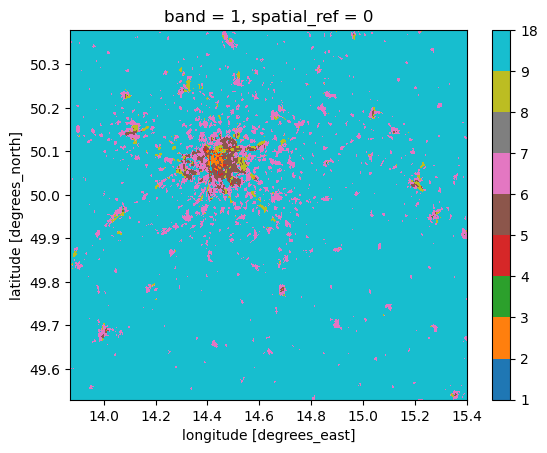

In [10]:
region_lczs.plot(levels=[1,2,3,4,5,6,7,8,9,18], cmap="tab10")

#### Generate spatial join

In [ ]:
%%time

results = []

for region_id in regions.index:

    print(region_id)
    buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq')

    # setup geometry list to burn into the raster
    buildings['num_index'] = np.arange(1, buildings.shape[0] + 1)
    buildings['geometry'] = buildings.representative_point()
    building_utm = buildings.to_crs(lczs.rio.crs)
    minx, miny, maxx, maxy = building_utm.total_bounds


    # read only the region part of the raster data
    region_lczs = rioxarray.open_rasterio(
        filename=furl,
        chunks='auto',
        parse_coordinates=True,
        masked=True
    ).rio.clip_box(minx, miny, maxx, maxy)

    # extract building classification from lcz raster
    aggregated_iterative = region_lczs.xvec.extract_points(
        building_utm.geometry,
        x_coords="x",
        y_coords="y",
    )

    # append to the building dataframe and store in the  results array
    res = aggregated_iterative.to_pandas()
    res = gpd.GeoDataFrame(res.T.reset_index(), crs=building_utm.crs)
    res.columns = ['geometry', 'label']
    building_utm['lcz'] = res['label'].values
    results.append(building_utm)

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


In [11]:
all_data = pd.concat(results, ignore_index=True)

In [12]:
del results

### Crossstab

In [13]:
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')

In [14]:
cluster_mapping

1  2  3   4   5   6
7                       
4    1  1  1   1   2   3
6    1  1  1   1   2   4
88   2  4  7  13  20  48
3    1  1  1   1   2   3
103  2  4  8  17  24  55
..  .. .. ..  ..  ..  ..
20   1  2  3   4   6  10
63   2  3  6  10  15  32
61   2  3  6   9  14  30
11   1  1  2   2   3   7
46   1  2  5   7  11  22

[110 rows x 6 columns]

In [15]:
all_data['map_label'] = all_data['final_without_noise'].map(cluster_mapping[3].to_dict())

In [16]:
lcz_names = {
    "1": "Compact high-rise",
    "2": "Compact mid-rise",
    "3": "Compact low-rise",
    "4": "Open high-rise",
    "5": "Open mid-rise",
    "6": "Open low-rise",
    "7": "Lightweight low-rise",
    "8": "Large low-rise",
    "9": "Sparsely built",
    "10": "Heavy industry",
    "11": "Dense trees",
    "12": "Scattered trees",
    "13": "Bush, scrub",
    "14": "Low plants",
    "15": "Bare rock or paved",
    "16": "Bare soil or sand",
    "17": "Water"
}

lcz_names = {float(k):v for k,v in lcz_names.items()}

In [17]:
all_data.lcz.value_counts() / all_data.shape[0]

lcz
6.0     4.703750e-01
9.0     2.774260e-01
14.0    1.024760e-01
12.0    5.933093e-02
11.0    3.232364e-02
5.0     3.119549e-02
8.0     1.802161e-02
2.0     5.205505e-03
4.0     1.362793e-03
3.0     1.245510e-03
10.0    3.347574e-04
1.0     2.384158e-04
17.0    1.937229e-04
15.0    1.333361e-04
16.0    3.132588e-05
7.0     1.633748e-06
13.0    7.673665e-07
Name: count, dtype: float64

In [18]:
himoc_lcz_tab = pd.crosstab(all_data.map_label, all_data.lcz, normalize='index')
himoc_lcz_tab.index = himoc_lcz_tab.index.map(get_cluster_names(3)).values
himoc_lcz_tab.columns = himoc_lcz_tab.columns.map(lcz_names).values


In [19]:
himoc_lcz_tab.columns

Index(['Compact high-rise', 'Compact mid-rise', 'Compact low-rise',
       'Open high-rise', 'Open mid-rise', 'Open low-rise',
       'Lightweight low-rise', 'Large low-rise', 'Sparsely built',
       'Heavy industry', 'Dense trees', 'Scattered trees', 'Bush, scrub',
       'Low plants', 'Bare rock or paved', 'Bare soil or sand', 'Water'],
      dtype='object')

In [20]:
selected_cols = ['Compact high-rise', 'Compact mid-rise',
       'Open mid-rise', 'Open low-rise',
       'Large low-rise', 'Sparsely built',
       'Heavy industry', 'Dense trees', 'Scattered trees',
       'Low plants']

In [21]:
styled_df = himoc_lcz_tab[selected_cols]

f = {
    k: "{:.2f}" for k in himoc_lcz_tab.columns.values
}
styled_df = himoc_lcz_tab.style.format(f).background_gradient(axis=1, cmap="BuGn")
styled_df

in all cases more than 70% of the buildings are assigned to 1 or 2 classes.

In [22]:
await dfi.export_async(styled_df, '../data/lcz.png', dpi=300)

In [23]:
all_data.map_label.value_counts() / all_data.shape[0]

map_label
7    0.427676
5    0.158930
4    0.145220
3    0.091386
8    0.088947
1    0.040571
2    0.029568
6    0.017703
Name: count, dtype: float64

In [94]:
# building_utm.iloc[160_000: 190_000].explore(column='lcz', categorical=True, prefer_canvas=True, tiles='cartodb positron')

## Figures

### Taxonometric tree overview

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import to_hex
from matplotlib import colormaps
import matplotlib.patches as mpatches
import shapely
from core.utils import get_cluster_names

region_hulls = regions = gpd.read_parquet("/data/uscuni-ulce/regions/cadastre_regions_hull.parquet")

v = 'v10'


In [2]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'

model_params = '_post_processing_v1'

clip = None
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
          'licBAD', 'misBAD',
    'ssbCCM','ssbCCD'
]


linkage = 'ward'
metric = 'euclidean'

morphotope_stat_columns = ['percentile_25', 'percentile_75', 'mean', 'std']

In [3]:
def preprocess_data(data, scalar, drop_columns=morphotope_stat_columns):
    component_data = data.drop(columns=drop_columns, level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  component_data.columns.get_level_values(0)

    component_data = component_data[component_data.index.str[-2:] != '-1']

    vals = scalar.fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id, scalar, read_extra=False):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')

    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data, scalar)


    if read_extra:
        extra_chars = pd.read_parquet(f'{morphotopes_dir}morph_chars_{region_id}.pq')
        vals = scalar.fit_transform(extra_chars)
        extra_chars = pd.DataFrame(vals, columns=extra_chars.columns, index=extra_chars.index).fillna(0)
        extra_chars = extra_chars.drop(component_data.columns[component_data.std() == 0], axis=1)
        extra_chars = extra_chars[['limLPS']]
        extra_chars['limLPS2'] = extra_chars['limLPS']

        merged_data = pd.merge(component_data, extra_chars, how='inner', left_index=True, right_index=True)
        pd.testing.assert_index_equal(merged_data.index, component_data.index)
        component_data = merged_data

    return component_data

def get_morphotope_linkage(region_data):

    clusterer = AgglomerativeClustering(linkage=linkage,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def get_all_clusters(cutoff):

    all_clusters = []

    for region_id, _ in region_hulls.iterrows():
        data = read_region_morphotope_data(region_id, scalar=StandardScaler())
        region_index = data.index
        linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}.npy')
        clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
        clusters = pd.Series(clusters, region_index).astype(str)
        clusters = str(region_id) + '_' +clusters
        all_clusters.append(clusters)

    all_clusters = pd.concat(all_clusters)

    return all_clusters


def read_morphotopes_data(model_params):

    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
        region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
        data.append(region_morphotope_data)

    data = pd.concat(data)
    return data

def read_morphotopes_chars():

    data = []
    for region_id, _ in region_hulls.iterrows():
        extra_chars = pd.read_parquet(f'{morphotopes_dir}morph_chars_{region_id}.pq')
        data.append(extra_chars)

    data = pd.concat(data)
    return data


def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')

    etcs['label'] = -1

    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [4]:
%%time
# read morphotopes data
morphotopes_data = read_morphotopes_data(model_params)
morphotopes_data = morphotopes_data[~morphotopes_data.index.str.endswith('-1')]
morphotopes_data = morphotopes_data.iloc[:, :-1]

## drop unwanted columns
component_data = morphotopes_data.drop(columns=morphotope_stat_columns, level=1)
component_data = component_data.drop(columns=to_drop, level=0)
component_data.columns = component_data.columns.get_level_values(0)

# add morphotope variables
morph_chars_data = read_morphotopes_chars()
morph_chars_data = morph_chars_data[['limLPS', 'limAre', 'limPer']]
merged_data = pd.merge(component_data, morph_chars_data, how='inner', left_index=True, right_index=True)
pd.testing.assert_index_equal(merged_data.index, component_data.index)
component_data = merged_data

CPU times: user 24.3 s, sys: 7.77 s, total: 32.1 s
Wall time: 17.1 s


In [5]:

grouped_data = component_data

# drop outliers
grouped_data = grouped_data.drop(grouped_data[(grouped_data['limAre'] > 5e5) | (grouped_data['limPer'] > 2e5) | (grouped_data['ldbPWL'] > 5_000) | (grouped_data.sdbAre < 20)].index)

# drop columns
grouped_data = grouped_data.drop(['ssbCor', 'mtdDeg', 'limPer',  'mtbSWR'], axis=1)

In [6]:
%%time
morph_mapping = pd.read_parquet('/data/uscuni-ulce/data_product/buildings.parquet', columns=['morph', 'level_5_label'])
morph_mapping = morph_mapping.drop_duplicates('morph').set_index('morph')
morph_mapping = morph_mapping.loc[grouped_data.index]

CPU times: user 35.3 s, sys: 8.71 s, total: 44 s
Wall time: 40.8 s


In [10]:
counts = grouped_data.groupby(morph_mapping.level_5_label)['sdbAre'].count()
counts.to_list()

[2060,
 18992,
 685,
 5328,
 5347,
 6052,
 21252,
 10336,
 26454,
 28294,
 4,
 22834,
 69598,
 3,
 535,
 1833,
 7636,
 29677,
 43803,
 67101,
 7607,
 100055,
 56,
 15962,
 10424,
 17331]

In [8]:
cdata = grouped_data.groupby(morph_mapping.level_5_label).median()

In [12]:
cdata.to_parquet("cdata.parquet")

In [13]:
cdata

sdbAre      sdbPer    sdbCoA    ssbCCo     ssbSqu  \
level_5_label                                                          
1              389.775612   94.278728  0.000000  0.413456   0.358902   
2              148.794378   53.734088  0.000000  0.511426   0.281255   
3              249.431231   74.286443  0.000000  0.485651   0.192217   
4               96.064721   42.558750  0.000000  0.533083   0.228576   
5              177.948898   61.043586  0.000000  0.507410   0.198803   
6               98.862321   42.402569  0.000000  0.538172   0.242174   
7               95.526828   41.760554  0.000000  0.535104   0.267246   
8              102.556652   43.068806  0.000000  0.550011   0.234596   
9              105.311071   43.691162  0.000000  0.557216   0.267059   
10              97.611169   42.189379  0.000000  0.541891   0.264678   
11              51.879491   30.450927  0.000000  0.584952   0.023620   
12             116.038122   46.684548  0.000000  0.551784   0.382473   
13              74.632207   36.872001  0.000000  0.559694   0.263822   
14             649.496641  143.020734  7.199948  0.527600   7.715263   
15             146.283037   53.881824  0.000000  0.484321   2.038897   
16             125.692369   49.124841  0.000000  0.505678   1.874596   
17             130.794276   49.742087  0.000000  0.511782   1.773892   
18              81.123799   38.133171  0.000000  0.570858   0.283523   
19              60.677010   33.475166  0.000000  0.562250   0.231376   
20              65.509533   34.755390  0.000000  0.543335   0.320090   
21              60.454894   33.384114  0.000000  0.560825   0.212330   
22              66.760641   34.935515  0.000000  0.564309   0.231342   
23              84.587142   34.098234  0.000000  0.972961  90.000000   
24              62.070830   33.614651  0.000000  0.522129   0.230199   
25             117.743411   48.194359  0.000000  0.502469   1.020057   
26              70.372163   36.226831  0.000000  0.526470   1.510986   

                 ssbERI    ssbElo  libNCo       ldbPWL    ltcBuA  ...  \
level_5_label                                                     ...   
1              0.996464  0.456751     0.0   126.454408  0.894444  ...   
2              0.999039  0.590590     0.0   102.379725  0.750000  ...   
3              0.999648  0.530779     0.0   219.051294  0.692308  ...   
4              0.999548  0.644085     0.0    71.963415  0.777778  ...   
5              0.999717  0.570805     0.0   117.565312  0.777778  ...   
6              0.999939  0.623313     0.0    47.995019  1.000000  ...   
7              0.999915  0.613151     0.0    50.268573  0.904545  ...   
8              0.999881  0.668534     0.0    48.110038  1.000000  ...   
9              0.999077  0.705214     0.0    49.448345  1.000000  ...   
10             0.999813  0.646167     0.0    52.463682  0.875000  ...   
11             1.000012  0.734780     0.0    53.147409  0.857143  ...   
12             0.965352  0.722922     0.0    53.344403  1.000000  ...   
13             0.999744  0.698050     0.0    52.592053  0.833333  ...   
14             0.737475  0.755770    10.0   329.246434  0.571429  ...   
15             0.970264  0.623165    11.0  1337.963130  0.285714  ...   
16             0.975644  0.644677     3.0   887.206018  0.333333  ...   
17             0.977839  0.646241     1.0   471.350165  0.400000  ...   
18             0.996807  0.745326     0.0    47.813419  0.875000  ...   
19             0.999321  0.719322     0.0    56.482971  0.750000  ...   
20             0.999176  0.668461     0.0    73.998526  0.666667  ...   
21             0.999553  0.713910     0.0    59.172864  0.750000  ...   
22             0.999425  0.723905     0.0    57.192336  0.800000  ...   
23             1.120943  0.993167     0.0    43.923314  1.000000  ...   
24             0.999574  0.586255     0.0   131.932942  0.500000  ...   
25             0.964862  0.637332     0.0   111.728074  0.666667  ...   
26             0.996158  0.6531

In [109]:
# cdata = cdata[cdata.index.isin(counts[counts>1000].index)]

In [110]:
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
from core.utils import get_cluster_names

In [ ]:
all_data = pd.concat((cdata, grouped_data))
scalar = StandardScaler()
vals = scalar.fit_transform(all_data)
all_data = pd.DataFrame(vals, index=all_data.index, columns=all_data.columns).dropna()

# setup tree data
query_data = all_data.loc[cdata.index]
tree_data = all_data.loc[grouped_data.index[grouped_data.index.isin(all_data.index)]]

In [112]:
%%time
tree = KDTree(tree_data)
dists, nns = tree.query(query_data, k=10)

CPU times: user 6.75 s, sys: 9.44 ms, total: 6.76 s
Wall time: 13.5 s


In [113]:
nearest_morphs = pd.Series(tree_data.index[nns[:, -1]], index=cdata.index)

In [114]:
%%time

# load the etcs for the specific nearest neigbhours morphs
morph_regions = nearest_morphs.str.split('_').str[0].values
nn_etcs = []
for region in np.unique(morph_regions):
    region_etcs = morphotopes_to_etcs(region, etcs=False, model_params=model_params)
    region_etcs = region_etcs[region_etcs.morph.isin(nearest_morphs)]
    nn_etcs.append(region_etcs)

nn_etcs = pd.concat(nn_etcs)

CPU times: user 2min 12s, sys: 5.67 s, total: 2min 18s
Wall time: 3min 20s


In [115]:
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')
cm = pd.Series(cluster_mapping[3].values, cluster_mapping[5].values)
cm[~cm.index.duplicated()].sort_index().map(get_cluster_names(3))

1       Incoherent Large-Scale Homogeneous Fabric
2       Incoherent Large-Scale Homogeneous Fabric
3     Incoherent Large-Scale Heterogeneous Fabric
4     Incoherent Large-Scale Heterogeneous Fabric
5     Incoherent Large-Scale Heterogeneous Fabric
6            Incoherent Small-Scale Linear Fabric
7            Incoherent Small-Scale Linear Fabric
8            Incoherent Small-Scale Sparse Fabric
9            Incoherent Small-Scale Sparse Fabric
10           Incoherent Small-Scale Sparse Fabric
11          Incoherent Small-Scale Compact Fabric
12          Incoherent Small-Scale Compact Fabric
13          Incoherent Small-Scale Compact Fabric
14                 Coherent Interconnected Fabric
15                 Coherent Interconnected Fabric
16                 Coherent Interconnected Fabric
17                 Coherent Interconnected Fabric
18                 Coherent Dense Disjoint Fabric
19                 Coherent Dense Disjoint Fabric
20                 Coherent Dense Disjoint Fabric


In [116]:

# nn_etcs[nn_etcs.morph == nearest_morphs.loc[2]].explore()

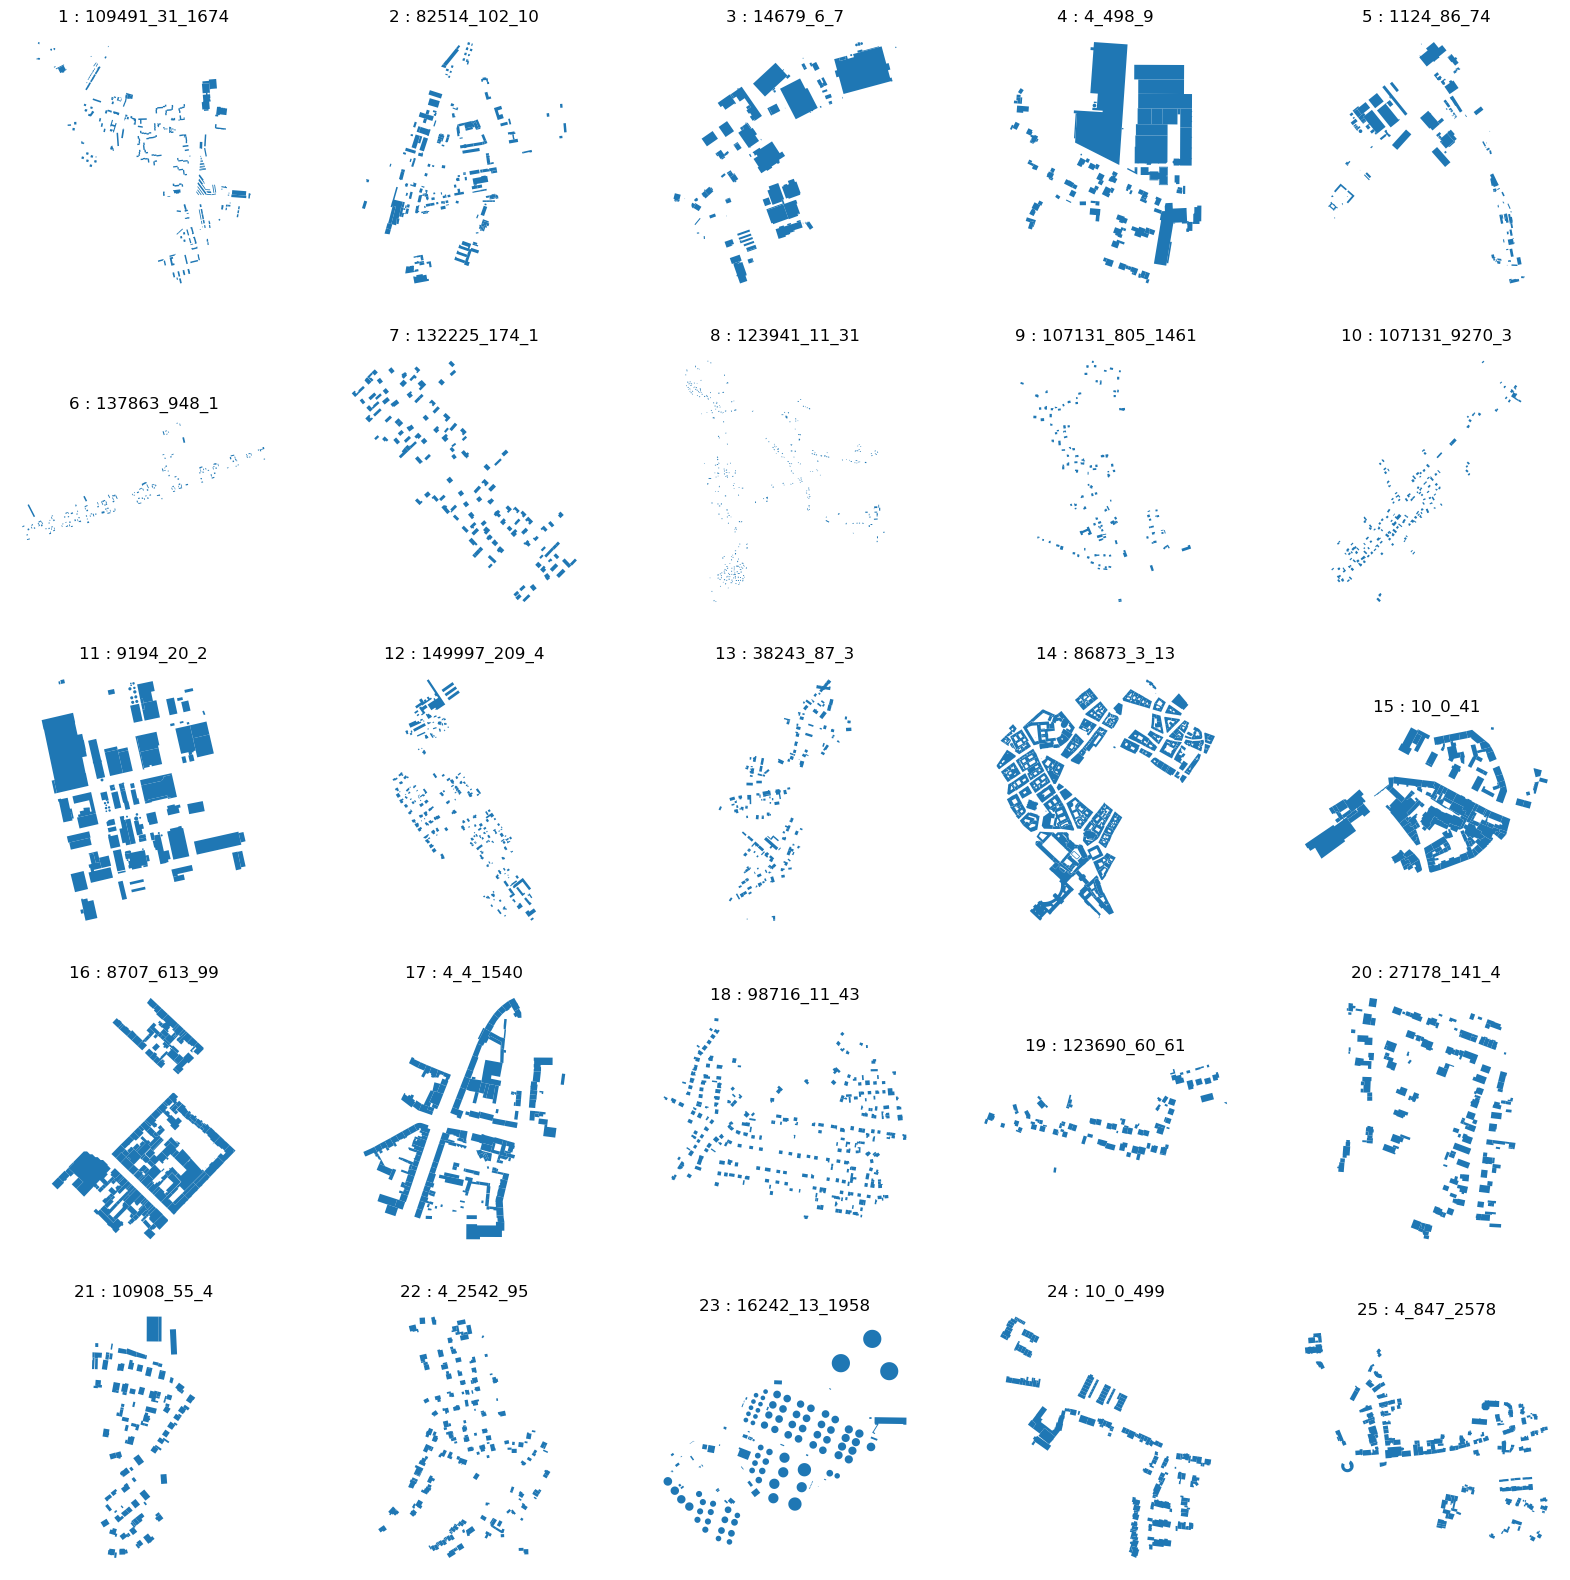

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
for i, ax in zip(cdata.index, axes.flatten()):

    morph = nearest_morphs.loc[i]
    morph_buildings = nn_etcs[nn_etcs.morph == morph]
    morph_buildings.plot(ax=ax)
    ax.set_title(str(i) + ' : ' + morph)

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)



### Taxonomy across settlement hierarchy examples

In [3]:
# 74378 - Milevsko, Czechia
# 35141 - Insbruck, Austria
# 107131 - Krakow, Poland
# 55763 - Berlin, Germany

centres_df = pd.DataFrame(((49.45118, 14.36031), (47.26446 , 11.40490), (50.06084, 19.93810), (52.49891 , 13.39149)), columns=['y', 'x'])
centres_df = gpd.GeoSeries(gpd.points_from_xy(centres_df['x'], centres_df['y'], crs='epsg:4236')).to_crs(epsg=3035)

In [4]:
buffers = [1000, 2000, 4000, 8000]

In [ ]:
%%time

milevsko = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_74378_{v}.pq', columns=['final_without_noise', 'geometry'])
milevsko = milevsko[milevsko.within(centres_df.iloc[0].buffer(buffers[0]))]
insbruck = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_35141_{v}.pq', columns=['final_without_noise', 'geometry'])
insbruck = insbruck[insbruck.within(centres_df.iloc[1].buffer(buffers[1]))]
krakow = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_107131_{v}.pq', columns=['final_without_noise', 'geometry'])
krakow = krakow[krakow.within(centres_df.iloc[2].buffer(buffers[2]))]
berlin = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_55763_{v}.pq', columns=['final_without_noise', 'geometry'])
berlin = berlin[berlin.within(centres_df.iloc[3].buffer(buffers[3]))]

CPU times: user 2.88 s, sys: 1 s, total: 3.88 s
Wall time: 3.64 s


In [6]:
# Latitude: 49.45118 Longitude: 14.36031
# Latitude: 47.26446 Longitude: 11.40490
# Latitude: 50.06084 Longitude: 19.93810
# Latitude: 52.49891 Longitude: 13.39149

In [7]:
datalist = [milevsko, insbruck, krakow, berlin]

<timed exec>:12: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
<timed exec>:12: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
<timed exec>:12: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.


CPU times: user 1min 14s, sys: 116 ms, total: 1min 14s
Wall time: 1min 14s


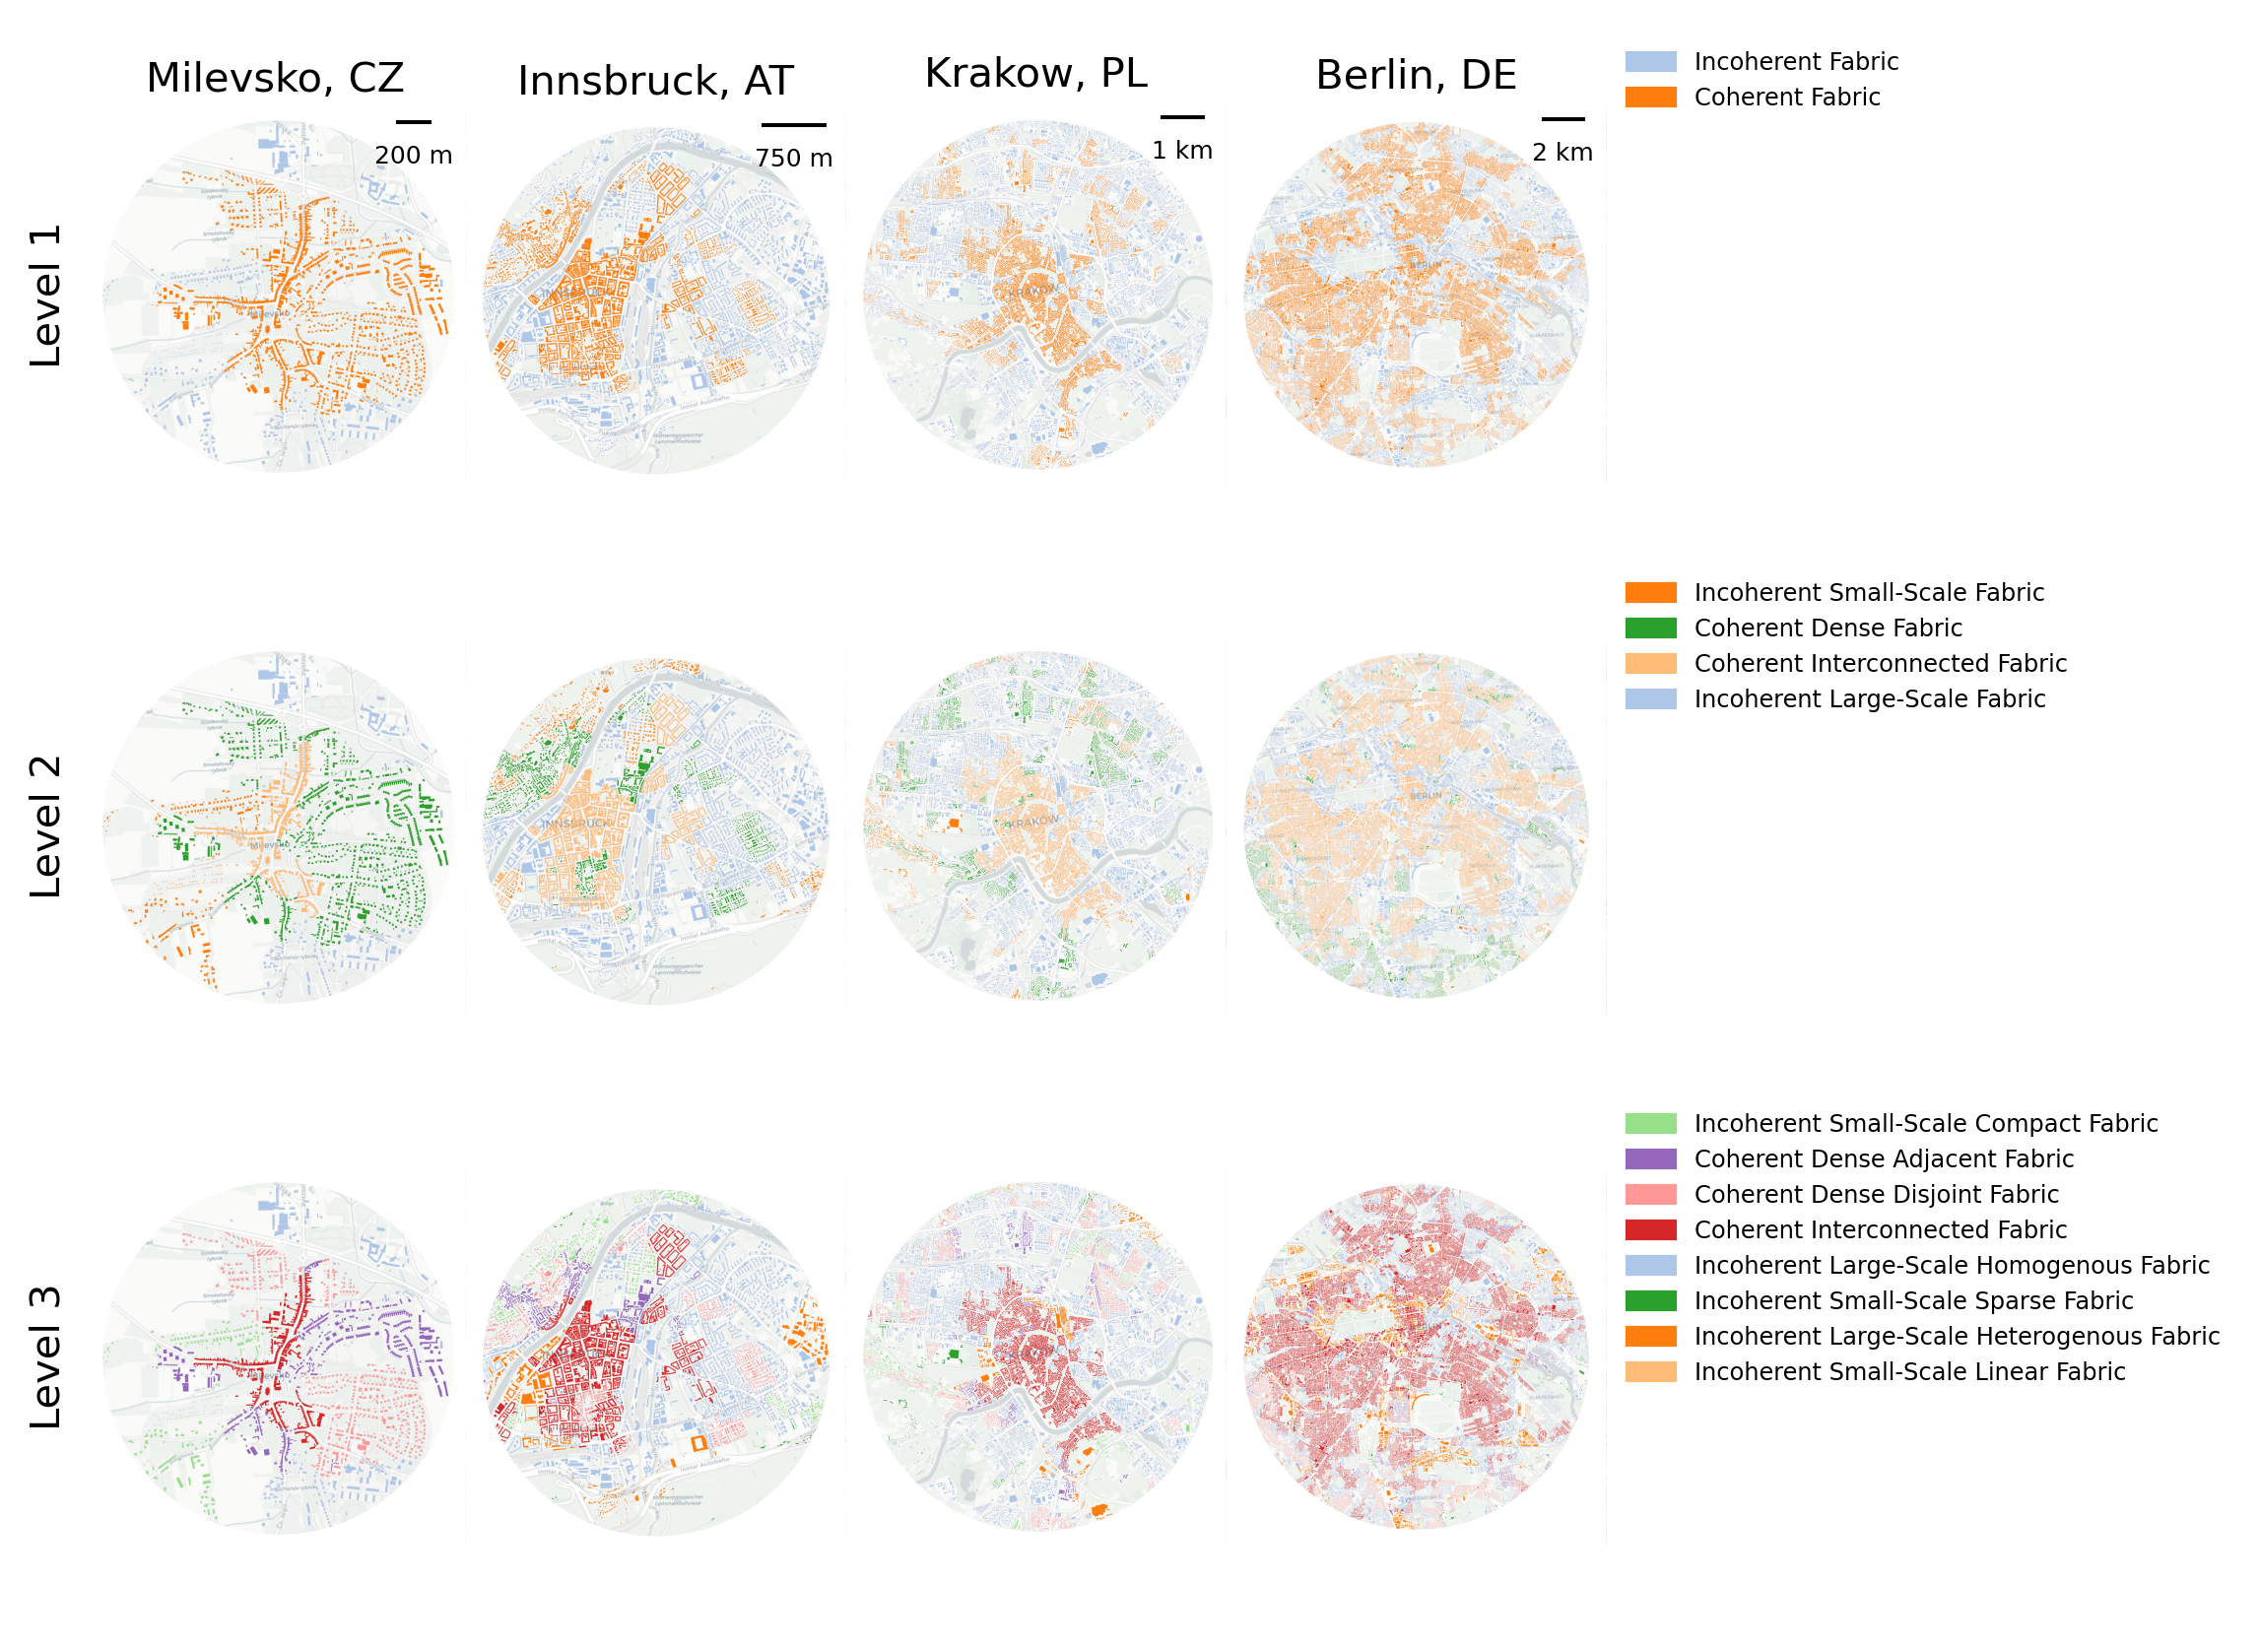

In [ ]:
%%time

cmap = [to_hex(c) for c in colormaps.get_cmap('tab20').colors]

levels = 3

fig, ax = plt.subplots(levels ,5, figsize=(8.3, 7), dpi=300)
for level, row_ax in enumerate(ax):

    clusters = [data.final_without_noise.map(cluster_mapping[level + 1].to_dict()) for data in datalist]
    unique_clusters = pd.concat(clusters, ignore_index=True).unique()

    for i, (data, col_ax) in enumerate(zip(datalist, row_ax[:-1])):

        for cluster in unique_clusters:
            data[clusters[i] == cluster].plot(ax=col_ax, color=cmap[cluster])

        cx.add_basemap(col_ax, crs=data.crs, source=cx.providers.CartoDB.Positron.build_url(scale_factor="@2x",), attribution='')
        axis_box = shapely.box(col_ax.get_xlim()[0], col_ax.get_ylim()[0], col_ax.get_xlim()[1], col_ax.get_ylim()[1])
        axis_waste = axis_box.difference(centres_df.iloc[i].buffer(buffers[i]))
        gpd.GeoSeries([axis_waste], crs=data.crs).plot(ax=col_ax, color='w')

        if level == 0:
            col_ax.add_artist(ScaleBar(1, location="upper right", frameon=False, font_properties={"size": 6}))

    legend_patches = [mpatches.Patch(color=cmap[cluster], label=get_cluster_names(level + 1)[cluster]) for cluster in unique_clusters]
    row_ax[-1].legend(handles=legend_patches, loc='upper left', frameon=False, fontsize='xx-small')

ax[0][0].set_ylabel('Level 1')
ax[1][0].set_ylabel('Level 2')
ax[2][0].set_ylabel('Level 3')

ax[0][0].set_xlabel('Milevsko, CZ')
ax[0][0].xaxis.set_label_position('top')
ax[0][1].set_xlabel('Innsbruck, AT')
ax[0][1].xaxis.set_label_position('top')
ax[0][2].set_xlabel('Krakow, PL')
ax[0][2].xaxis.set_label_position('top')
ax[0][3].set_xlabel('Berlin, DE')
ax[0][3].xaxis.set_label_position('top')

for paxis in ax.flatten():
    paxis.set_yticks([])
    paxis.set_xticks([])
    paxis.set_frame_on(False)

fig.subplots_adjust(wspace = 0.00, hspace=0.00)
fig.savefig('../data/examples.png')

### Deeper Taxonomy level examples

In [12]:
from core.cluster_validation import get_color

In [13]:
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')


In [14]:
centres_df = pd.DataFrame(((50.08873, 14.41810), ), columns=['y', 'x'])
centres_df = gpd.GeoSeries(gpd.points_from_xy(centres_df['x'], centres_df['y'], crs='epsg:4236')).to_crs(epsg=3035)

In [15]:
prague = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_69333_{v}.pq', columns=['final_without_noise', 'geometry'])
prague = prague[prague.within(centres_df.buffer(3_500).iloc[0])]

CPU times: user 13.7 s, sys: 16.2 ms, total: 13.7 s
Wall time: 10.8 s


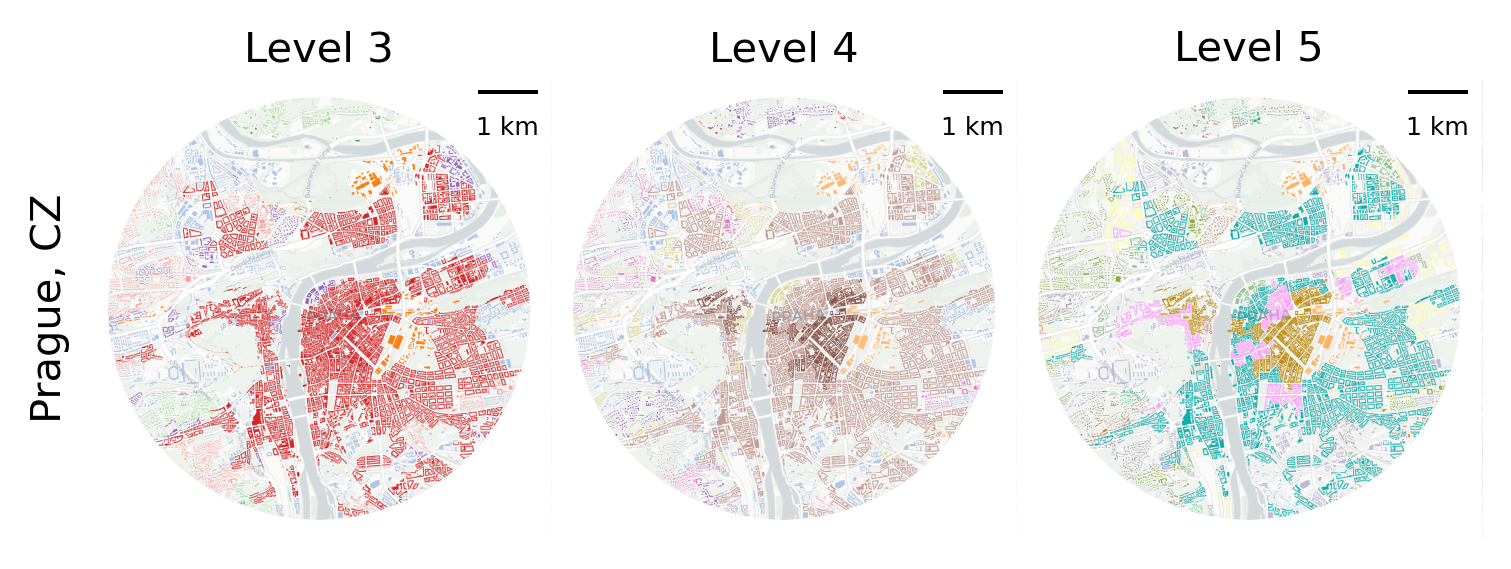

In [ ]:
%%time

levels = [3, 4, 5]

cmap = [to_hex(c) for c in colormaps.get_cmap('tab20').colors]

fig, ax = plt.subplots(1,3, figsize=(6, 2), dpi=300)

for level, col_ax in zip(levels, ax):

    if level < 7:
        clusters = prague.final_without_noise.map(cluster_mapping[level].to_dict())
    else:
        clusters = prague.final_without_noise

    unique_clusters = clusters.unique()

    if level <= 4:
        cmap = [to_hex(c) for c in colormaps.get_cmap('tab20').colors]
    else:
        cmap = ['#%02x%02x%02x' % (c[0], c[1], c[2]) for c in get_color(np.arange(0, max(unique_clusters) + 1))]

    for cluster in unique_clusters:
        prague[clusters == cluster].plot(ax=col_ax, color=cmap[cluster])

    cx.add_basemap(col_ax, crs=prague.crs, source=cx.providers.CartoDB.Positron.build_url(scale_factor="@2x",), attribution='')
    axis_box = shapely.box(col_ax.get_xlim()[0], col_ax.get_ylim()[0], col_ax.get_xlim()[1], col_ax.get_ylim()[1])
    axis_waste = axis_box.difference(centres_df.iloc[0].buffer(3_500))
    gpd.GeoSeries([axis_waste], crs=prague.crs).plot(ax=col_ax, color='w')
    col_ax.add_artist(ScaleBar(1, location="upper right", frameon=False, font_properties={"size": 6}))

ax[0].set_ylabel('Prague, CZ')

ax[0].set_xlabel(f'Level {levels[0]}')
ax[0].xaxis.set_label_position('top')
ax[1].set_xlabel(f'Level {levels[1]}')
ax[1].xaxis.set_label_position('top')
ax[2].set_xlabel(f'Level {levels[2]}')
ax[2].xaxis.set_label_position('top')

for paxis in ax.flatten():
    paxis.set_yticks([])
    paxis.set_xticks([])
    paxis.set_frame_on(False)

fig.subplots_adjust(wspace = 0.00, hspace=0.00)
fig.savefig('../data/prague_taxonomy.png')

### Country breakdown - counts

In [18]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [19]:
## download countries
# !wget https://gisco-services.ec.europa.eu/distribution/v2/countries/geojson/CNTR_RG_01M_2024_3035.geojson


In [20]:
country_names = ['Germany', 'Poland', 'Czechia', 'Slovakia', 'Austria', 'Lithuania']
countries = gpd.read_file('../data/CNTR_RG_01M_2024_3035.geojson').to_crs(epsg=3035)
country_polygons = countries[countries['NAME_ENGL'].isin(country_names)]

region_hulls = gpd.read_parquet("/data/uscuni-ulce/regions/cadastre_regions_hull.parquet")

v = 'v10'
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')

In [ ]:
region_idxs, country_idxs = country_polygons.sindex.query(region_hulls.geometry, predicate='intersects')
intersections = region_hulls.iloc[region_idxs].intersection(country_polygons.iloc[country_idxs], align=False).area
intersection_df = gpd.GeoDataFrame(
    {
    'region_id': region_hulls.index[region_idxs].values,
    'country': country_polygons.iloc[country_idxs, 2].values,
    'intersection_area': intersections.values,
    'geometry': region_hulls.iloc[region_idxs, 0].values
    },
    crs=region_hulls.crs


)

intersection_df = intersection_df.sort_values('intersection_area', ascending=False)

In [22]:
intersection_df.sort_values('region_id')

region_id    country  intersection_area  \
0            4    Germany       3.946676e+10   
1           10    Germany       1.495455e+09   
2          132    Germany       1.727289e+08   
3          134    Germany       5.064500e+07   
4          286    Germany       5.871000e+07   
..         ...        ...                ...   
921     149997  Lithuania       1.884045e+09   
922     150044  Lithuania       2.080685e+09   
923     151676  Lithuania       5.997051e+09   
924     152081  Lithuania       8.335309e+09   
925     152511  Lithuania       3.360046e+09   

                                              geometry  
0    POLYGON ((4122200 3045600, 4121500 3045900, 40...  
1    POLYGON ((4068900 3057300, 4051000 3064300, 40...  
2    POLYGON ((4053100 3049800, 4050900 3053000, 40...  
3    POLYGON ((4052500 3093600, 4052200 3093700, 40...  
4    POLYGON ((4060600 3103900, 4057000 3104200, 40...  
..                                                 ...  
921  POLYGON ((5253200 3642300, 5245600 3647000, 52...  
922  POLYGON ((5265700 3578300, 5263400 3578400, 52...  
923  POLYGON ((5285400 3549200, 5284800 3549900, 52...  
924  POLYGON ((5269700 3664900, 5269300 3665300, 52...  
925  POLYGON ((5298200 3650100, 5279200 3651600, 52...  

[926 rows x 4 columns]

In [ ]:
%%time

results = []
results_area = []

for country, group in intersection_df.groupby('country')['region_id']:

    print(country)

    country_polygon = countries[countries['NAME_ENGL'] == country].geometry.iloc[0]
    cluster_data = pd.concat(
    [
        gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{rid}_{v}.pq', columns=['final_without_noise', 'geometry'])
        for rid in group.values
    ], ignore_index=True
    )

    within_country = cluster_data.sindex.query(country_polygon, predicate='contains')

    # save counts
    counts = cluster_data.iloc[within_country]['final_without_noise'].value_counts()
    counts.name = country
    results.append(counts)

    # save areas
    areas = cluster_data.iloc[within_country].groupby('final_without_noise')['geometry'].apply(lambda x: x.area.sum())
    areas.name = country
    results_area.append(areas)

total_counts = pd.concat(results, axis=1).fillna(0).sort_index()
total_areas = pd.concat(results_area, axis=1).fillna(0).sort_index()

Austria
Czechia
Germany
Lithuania
Poland
Slovakia
CPU times: user 3min 24s, sys: 23.2 s, total: 3min 47s
Wall time: 3min 45s


In [29]:
level4_counts = total_counts.groupby(total_counts.index.map(cluster_mapping[3].to_dict()).values).sum()
level4_counts.index = level4_counts.index.map(get_cluster_names(3))

level3_counts = total_counts.groupby(total_counts.index.map(cluster_mapping[3].to_dict()).values).sum()

In [30]:
level4_areas = total_areas.groupby(total_areas.index.map(cluster_mapping[3].to_dict()).values).sum()
level4_areas.index = level4_areas.index.map(get_cluster_names(3))

In [31]:
# proportions in brackets

r1 = (level4_counts / 1_000).astype(int)
r2 = (level4_counts / level4_counts.sum(axis=0))

r3 = r1.copy().astype(str)
for i in range(r3.shape[0]):
    for j in range(r3.shape[1]):
        r3.iloc[i,j] = '{:,d}'.format(r1.iloc[i,j]) + ' (' + '{:,.2f}'.format(r2.iloc[i, j]) + ')'

r3

Austria       Czechia  \
Incoherent Large-Scale Homogenous Fabric      132 (0.03)    247 (0.06)   
Incoherent Large-Scale Heterogenous Fabric     97 (0.02)    104 (0.03)   
Incoherent Small-Scale Linear Fabric          223 (0.05)    226 (0.05)   
Incoherent Small-Scale Sparse Fabric        1,500 (0.34)  1,102 (0.27)   
Incoherent Small-Scale Compact Fabric       1,199 (0.27)  1,078 (0.26)   
Coherent Interconnected Fabric                113 (0.03)     81 (0.02)   
Coherent Dense Disjoint Fabric                788 (0.18)    681 (0.17)   
Coherent Dense Adjacent Fabric                308 (0.07)    609 (0.15)   

                                                  Germany   Lithuania  \
Incoherent Large-Scale Homogenous Fabric     1,911 (0.04)   67 (0.03)   
Incoherent Large-Scale Heterogenous Fabric   1,811 (0.04)   23 (0.01)   
Incoherent Small-Scale Linear Fabric         1,937 (0.04)  452 (0.22)   
Incoherent Small-Scale Sparse Fabric         3,149 (0.06)  621 (0.30)   
Incoherent Small-Scale Compact Fabric        6,813 (0.13)  506 (0.25)   
Coherent Interconnected Fabric               1,129 (0.02)    2 (0.00)   
Coherent Dense Disjoint Fabric              28,918 (0.56)  369 (0.18)   
Coherent Dense Adjacent Fabric               5,759 (0.11)    8 (0.00)   

                                                  Poland      Slovakia  
Incoherent Large-Scale Homogenous Fabric      780 (0.05)    137 (0.04)  
Incoherent Large-Scale Heterogenous Fabric    289 (0.02)     63 (0.02)  
Incoherent Small-Scale Linear Fabric        4,156 (0.27)    385 (0.11)  
Incoherent Small-Scale Sparse Fabric        5,122 (0.33)    234 (0.07)  
Incoherent Small-Scale Compact Fabric       2,510 (0.16)    730 (0.21)  
Coherent Interconnected Fabric                 76 (0.01)     25 (0.01)  
Coherent Dense Disjoint Fabric              2,024 (0.13)  1,768 (0.51)  
Coherent Dense Adjacent Fabric                408 (0.03)     91 (0.03)

In [32]:
# areas in brackets
r1 = (level4_counts / 1_000).astype(int)
r2 = (level4_areas / level4_areas.sum(axis=0))

r3 = r1.copy().astype(str)
for i in range(r3.shape[0]):
    for j in range(r3.shape[1]):
        r3.iloc[i,j] = '{:,d}'.format(r1.iloc[i,j]) + ' (' + '{:,.2f}'.format(r2.iloc[i, j]) + ')'

r3

Austria       Czechia  \
Incoherent Large-Scale Homogenous Fabric      132 (0.08)    247 (0.15)   
Incoherent Large-Scale Heterogenous Fabric     97 (0.09)    104 (0.11)   
Incoherent Small-Scale Linear Fabric          223 (0.04)    226 (0.05)   
Incoherent Small-Scale Sparse Fabric        1,500 (0.32)  1,102 (0.24)   
Incoherent Small-Scale Compact Fabric       1,199 (0.23)  1,078 (0.22)   
Coherent Interconnected Fabric                113 (0.05)     81 (0.03)   
Coherent Dense Disjoint Fabric                788 (0.12)    681 (0.11)   
Coherent Dense Adjacent Fabric                308 (0.08)    609 (0.10)   

                                                  Germany   Lithuania  \
Incoherent Large-Scale Homogenous Fabric     1,911 (0.10)   67 (0.12)   
Incoherent Large-Scale Heterogenous Fabric   1,811 (0.14)   23 (0.07)   
Incoherent Small-Scale Linear Fabric         1,937 (0.04)  452 (0.17)   
Incoherent Small-Scale Sparse Fabric         3,149 (0.07)  621 (0.30)   
Incoherent Small-Scale Compact Fabric        6,813 (0.11)  506 (0.21)   
Coherent Interconnected Fabric               1,129 (0.03)    2 (0.01)   
Coherent Dense Disjoint Fabric              28,918 (0.40)  369 (0.12)   
Coherent Dense Adjacent Fabric               5,759 (0.09)    8 (0.01)   

                                                  Poland      Slovakia  
Incoherent Large-Scale Homogenous Fabric      780 (0.14)    137 (0.12)  
Incoherent Large-Scale Heterogenous Fabric    289 (0.10)     63 (0.10)  
Incoherent Small-Scale Linear Fabric        4,156 (0.23)    385 (0.10)  
Incoherent Small-Scale Sparse Fabric        5,122 (0.28)    234 (0.07)  
Incoherent Small-Scale Compact Fabric       2,510 (0.13)    730 (0.17)  
Coherent Interconnected Fabric                 76 (0.01)     25 (0.01)  
Coherent Dense Disjoint Fabric              2,024 (0.09)  1,768 (0.40)  
Coherent Dense Adjacent Fabric                408 (0.02)     91 (0.03)

In [28]:
(level4_counts.T / level4_counts.sum(axis=1)).T.style.format(precision=2)